<a href="https://colab.research.google.com/github/Mohd-Abbas-Rizvi/ML-Project-DL_Neural_Network/blob/main/ecommerce_neural_net_for_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os, random
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import time
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

input_path = '/kaggle/input/ecommerce-events-history-in-cosmetics-shop'
for dirname, _, filenames in os.walk(input_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data overview

In [2]:
import keras
print(tf.__version__)
print(keras.__version__)


2.17.1
3.5.0


In [3]:
# from google.colab import files
# uploaded = files.upload()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load data
path = '/content/drive/My Drive/'
name = '2019-Oct'
data = pd.read_csv(f'{path}/{name}.csv')

In [5]:
print('Total number of data: ',len(data))
print('Total number of columns: ',len(data.columns))

Total number of data:  4102283
Total number of columns:  9


In [6]:
data.user_id.nunique()

399664

In [7]:
data.product_id.nunique()

41899

In [8]:
# Show duplicates
data[data.duplicated(keep=False)]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
12,2019-10-01 00:00:30 UTC,remove_from_cart,5809103,1487580013522845895,NaN,irisk,0.60,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
13,2019-10-01 00:00:30 UTC,remove_from_cart,5809103,1487580013522845895,NaN,irisk,0.60,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
29,2019-10-01 00:01:05 UTC,remove_from_cart,5858981,1487580007634043851,NaN,de.lux,0.79,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
30,2019-10-01 00:01:05 UTC,remove_from_cart,5858981,1487580007634043851,NaN,de.lux,0.79,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
34,2019-10-01 00:01:07 UTC,remove_from_cart,5312,1487580009471148064,NaN,runail,1.27,467916806,2f5b5546-b8cb-9ee7-7ecd-84276f8ef486
...,...,...,...,...,...,...,...,...,...
4102232,2019-10-31 23:56:18 UTC,remove_from_cart,5834736,1487580009445982239,NaN,NaN,3.02,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
4102244,2019-10-31 23:56:46 UTC,remove_from_cart,5776516,1487580009445982239,NaN,NaN,7.14,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
4102246,2019-10-31 23:56:46 UTC,remove_from_cart,5776516,1487580009445982239,NaN,NaN,7.14,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
4102249,2019-10-31 23:56:52 UTC,remove_from_cart,5834737,1487580009445982239,NaN,NaN,1.98,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb


In [9]:
# Copy to new dataframe to avoiding from adjusting the original dataframe
raw_data = data.copy()
print('Copy successfully')

Copy successfully


In [10]:
# Drop duplicates
data = data.drop_duplicates()

In [11]:
# Check duplicates
data[data.duplicated(keep=False)]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session


In [12]:
# Show dataset information
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3889128 entries, 0 to 4102282
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 296.7+ MB


In [13]:
# Summarize the training set
data.describe()

,product_id,category_id,price,user_id
count,3.889128e+06,3.889128e+06,3.889128e+06,3.889128e+06
mean,5.466216e+06,1.545765e+18,8.725351e+00,5.016975e+08
std,1.326391e+06,1.565820e+17,1.949236e+01,8.196493e+07
min,3.752000e+03,1.487580e+18,-7.937000e+01,4.103071e+06
25%,5.723488e+06,1.487580e+18,2.220000e+00,4.697598e+08
50%,5.809131e+06,1.487580e+18,4.110000e+00,5.396840e+08
75%,5.850498e+06,1.487580e+18,7.140000e+00,5.575529e+08
max,5.900470e+06,2.195085e+18,3.076000e+02,5.662808e+08


In [14]:
data.count()

,0
event_time,3889128
event_type,3889128
product_id,3889128
category_id,3889128
category_code,65379
brand,2317814
price,3889128
user_id,3889128
user_session,3888554


In [15]:
# Count null values
data.isnull().sum()

,0
event_time,0
event_type,0
product_id,0
category_id,0
category_code,3823749
brand,1571314
price,0
user_id,0
user_session,574


In [16]:
print('Total number of data: ',len(data))
print('Total number of columns: ',len(data.columns))

Total number of data:  3889128
Total number of columns:  9


In [17]:
num_users = data['user_id'].nunique()
num_products = data['product_id'].nunique()
num_categories = data['category_id'].nunique()
num_taxonomies = data['category_code'].nunique()
num_brands = data['brand'].nunique()
print('Total number of users: ',num_users)
print('Total number of products: ', num_products)
print('Total number of categories: ', num_categories)
print('Total number of taxonomies: ', num_taxonomies)
print('Total number of brands: ', num_brands)

Total number of users:  399664
Total number of products:  41899
Total number of categories:  490
Total number of taxonomies:  11
Total number of brands:  240


## 1. Category

In this section we will focus on the category of products which offer valuable information on customer behavior (the customer bahavior toward different categories, brands and price will be discussed in details later on). There are 2 types of category representations: **category_id** and **category_code**, both have its benefits:

- **Category ID:** The "category_id" is a numerical identifier assigned to each product category. It's a unique numerical code used to distinguish different categories from each other. It's often used for database indexing and efficient querying because numerical codes are faster to process than text-based codes.
    
- **Category Code (Product Taxonomy):** The **category_code** is a textual representation of a product's category within a taxonomy or hierarchy. It's a more human-friendly way to understand the product's category. It follows a hierarchical structure where the different levels of the category hierarchy are separated by periods (for examples: "appliances.environment.water_heater" or "furniture.living_room.sofa").

In many cases, the **category_code** is derived from the hierarchical structure of the taxonomy, and the **category_id** is used internally for database operations and indexing. Below image is an example for product taxonomy structure in an online shopping website (**Amazon**).


![Amazon product taxonomy online website](images/product-taxonomy-amazon.png)

Since **category_id** is used for the purpose of enhancing computing speed, it has less insight for analysis and less human-readable, thus we will focus mainly on **category_code**. From the data we can see that, **category_code** follows a hierarchical structure, where each level of the hierarchy is separated by periods. Specifically, it has a structure of **<category_1.category_2.category_3....>** with multiple levels. Let us separate those by the first period ('.'), split the category_code into 2 columns including **main_category** and **sub_category** and get a closer look.

<sup>*(Since the numbers of levels are different for different categories, therefore I just extract the categories before the first period as **main_category** while the rest as **sub_category**)*</sup>


In [18]:
data['category_code'].unique()

array([nan, 'appliances.environment.vacuum', 'stationery.cartrige',
       'apparel.glove', 'accessories.bag',
       'furniture.living_room.cabinet', 'furniture.bathroom.bath',
       'appliances.personal.hair_cutter', 'accessories.cosmetic_bag',
       'appliances.environment.air_conditioner',
       'furniture.living_room.chair', 'sport.diving'], dtype=object)

In [19]:
len(data.columns)

9

In [20]:
data[['main_category', 'sub_category']] = data['category_code'].str.split('.', n=1, expand=True)

In [21]:
data['category_code'].str.split('.', n=1, expand=True)

,0,1
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
4102278,NaN,NaN
4102279,NaN,NaN
4102280,NaN,NaN
4102281,NaN,NaN


In [22]:
data[['main_category', 'sub_category']] = data['category_code'].str.split('.', n=1, expand=True)
print('Splitted successfully.')

Splitted successfully.


In [23]:
data['main_category'].unique()

array([nan, 'appliances', 'stationery', 'apparel', 'accessories',
       'furniture', 'sport'], dtype=object)

In [24]:
data['sub_category'].unique()

array([nan, 'environment.vacuum', 'cartrige', 'glove', 'bag',
       'living_room.cabinet', 'bathroom.bath', 'personal.hair_cutter',
       'cosmetic_bag', 'environment.air_conditioner', 'living_room.chair',
       'diving'], dtype=object)

In [25]:
# PIPE 1
# Split by the first period (n=1)
data[['main_category', 'sub_category']] = data['category_code'].str.split('.', n=1, expand=True)
print('Splitted successfully.')
# Rearrange the columns
data = data.drop(columns=['category_code'])
new_order = ['event_time', 'event_type', 'product_id', 'category_id', 'main_category', 'sub_category', 'brand', 'price', 'user_id', 'user_session']
data = data[new_order]
print('Rearranged successfully.')
data.head(10)

Splitted successfully.
Rearranged successfully.


,event_time,event_type,product_id,category_id,main_category,sub_category,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
5,2019-10-01 00:00:16 UTC,cart,5857269,1487580005134238553,NaN,NaN,runail,2.62,430174032,73dea1e7-664e-43f4-8b30-d32b9d5af04f
6,2019-10-01 00:00:19 UTC,cart,5739055,1487580008246412266,NaN,NaN,kapous,4.75,377667011,81326ac6-daa4-4f0a-b488-fd0956a78733
7,2019-10-01 00:00:24 UTC,cart,5825598,1487580009445982239,NaN,NaN,NaN,0.56,467916806,2f5b5546-b8cb-9ee7-7ecd-84276f8ef486
8,2019-10-01 00:00:25 UTC,cart,5698989,1487580006317032337,NaN,NaN,NaN,1.27,385985999,d30965e8-1101-44ab-b45d-cc1bb9fae694
9,2019-10-01 00:00:26 UTC,view,5875317,2029082628195353599,NaN,NaN,NaN,1.59,474232307,445f2b74-5e4c-427e-b7fa-6e0a28b156fe


In [26]:
# Donut chart of main_category
mainCat_values = data.groupby('main_category')['product_id'].nunique().sort_values(ascending=False)
mainCat_names = mainCat_values.index
print(mainCat_values)
# Pie chart for main-categories
print('Number of main-categories: ', len(mainCat_names))
fig = px.pie(names=mainCat_names, values=mainCat_values, hole=0.3)
fig.update_layout({"title":{"text":"Main category distribution", "x":0.50}})
fig.show()

main_category
stationery     136
appliances     112
furniture       55
accessories     54
apparel         51
sport            1
Name: product_id, dtype: int64
Number of main-categories:  6


In [27]:
# Donut chart of sub_category - top 10
subCat_values = data.groupby('sub_category')['product_id'].nunique().sort_values(ascending=False)
subCat_names = subCat_values.index
print(subCat_values)
# Pie chart for sub-categories
print('Number of sub-categories: ', len(subCat_names))

# # Create a new array of sub-category values with the summed value of sub-categories not in top 10
other_value = subCat_values[10:].sum()
subCat_names_with_other = np.append(subCat_names[:10], 'Other')
subCat_values_with_other  = np.append(subCat_values[:10], other_value)

fig = px.pie(names=subCat_names_with_other , values=subCat_values_with_other , hole=0.3)
fig.update_layout({"title":{"text":"Sub category distribution", "x":0.50}})
fig.show()

sub_category
cartrige                       136
environment.vacuum              82
glove                           51
bathroom.bath                   48
bag                             38
environment.air_conditioner     22
cosmetic_bag                    16
personal.hair_cutter             8
living_room.cabinet              5
living_room.chair                2
diving                           1
Name: product_id, dtype: int64
Number of sub-categories:  11


In [28]:
# Is there any pair of main-categories has the same sub-category?

# Group main categories by sub-category and count the occurrences
main_cat_counts = data.groupby(['sub_category', 'main_category']).size().reset_index(name='count')

# Find pairs of main categories with the same sub-category
duplicate_pairs = main_cat_counts[main_cat_counts.duplicated(subset='sub_category', keep=False)]

# Display duplicate pairs
duplicate_pairs

,sub_category,main_category,count


In [29]:
# Create data of main and sub categories with counts of products
category_counts = data.drop_duplicates(subset='product_id').groupby(['main_category', 'sub_category']).size().reset_index(name='count')

# Treemap plot
fig = px.treemap(category_counts, path=[px.Constant("all"), 'main_category', 'sub_category'], values='count',
                  color='count', hover_data=['count'],
                  color_continuous_scale='YlGnBu',)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [30]:
no_categoryCode = data.drop_duplicates(subset='product_id')['main_category'].isna().sum()
no_categoryCode


41490

In [31]:
have_categoryCode = category_counts['count'].sum()
have_categoryCode

409

In [32]:
# There are many products have no code, the percentage are:
no_categoryCode = data.drop_duplicates(subset='product_id')['main_category'].isna().sum()
have_categoryCode = category_counts['count'].sum()
print('Percentage of products have category_code: {0:.2f}%'.format(100*have_categoryCode/(have_categoryCode+no_categoryCode)))
print('Percentage of products have NO category_code: {0:.2f}%'.format(100*no_categoryCode/(have_categoryCode+no_categoryCode)))

Percentage of products have category_code: 0.98%
Percentage of products have NO category_code: 99.02%


In [33]:
# Group products with category ids
catId_data = data.drop_duplicates(subset='product_id').groupby(['category_id'])

# Count for inconsistent id and code
non_consistent = 0
for cat_id, group in catId_data:
    unique_codes = group['sub_category'].unique() # since sub-categories reflect catergory codes

    if len(unique_codes) > 1:
        print(f"For category_id {cat_id}, multiple category_codes exist: {unique_codes}")
        non_consistent+=1

print(f"Found {non_consistent} inconsistent category_id and category_code")

Found 0 inconsistent category_id and category_code





## 1.2. Products with Zero-price

In [34]:
zero_price = data[data['price']==0]
zero_price.head(10)

,event_time,event_type,product_id,category_id,main_category,sub_category,brand,price,user_id,user_session
2454,2019-10-01 02:05:17 UTC,view,5892084,1597770225539875791,NaN,NaN,NaN,0.0,555458569,c048be2f-547d-4add-9bc6-09aa1e7ae9de
2614,2019-10-01 02:15:41 UTC,view,5892052,1487580010377117763,NaN,NaN,NaN,0.0,555455025,320f6021-30ac-4a58-ae17-bac1cc32aac3
5686,2019-10-01 04:25:00 UTC,view,5873432,2007399943458784057,apparel,glove,NaN,0.0,500054739,701220b4-45b4-4028-bcc3-5d77480253ff
6086,2019-10-01 04:33:15 UTC,view,5882605,1487580013522845895,NaN,NaN,NaN,0.0,523154930,caaf1f68-7b97-4d27-9c3d-8b28c2920ffd
8344,2019-10-01 05:16:30 UTC,view,5889621,1487580010561667147,NaN,NaN,NaN,0.0,523988665,00849bd2-fcd2-4cb4-af31-4e264f151848
8417,2019-10-01 05:18:03 UTC,view,5889622,1487580010561667147,NaN,NaN,NaN,0.0,523988665,80cfe614-f0a5-4101-a2b6-a21227590470
8465,2019-10-01 05:18:46 UTC,view,5889623,1487580010561667147,NaN,NaN,NaN,0.0,523988665,c2cd0464-3d2b-48e2-9667-bac248fe297a
8950,2019-10-01 05:24:38 UTC,view,5873431,2007399943458784057,apparel,glove,NaN,0.0,542778344,7c4f6972-ead8-46f1-85d4-e7d7028f06c3
10125,2019-10-01 05:38:01 UTC,view,5889627,1487580010561667147,NaN,NaN,NaN,0.0,523988665,8b2bf9d8-43f0-43b2-bed3-13b2c956cada
10154,2019-10-01 05:38:32 UTC,view,5889628,1487580010561667147,NaN,NaN,NaN,0.0,523988665,b7087089-41f5-48bc-b7eb-52fea86fa22c


It seems like those 0-price product has **no brand** and some are with **undefined category code**, let's check it out

In [35]:
zeroprice_total = zero_price['product_id'].nunique()
print('Total 0-price products: ', zeroprice_total)
nobrand_zeroprice_percentage = 100*zero_price[zero_price['brand'].isna()]['product_id'].nunique()/zeroprice_total
print('Pecentage of 0-price products has no brand: {0:.2f}%'.format(nobrand_zeroprice_percentage))
zeroprice_percentage = 100*zero_price['product_id'].nunique()/data['product_id'].nunique()
print('Pecentage of 0-price products per all products: {0:.2f}%'.format(zeroprice_percentage))
nobrand_percentage = 100*data[data['brand'].isna()]['product_id'].nunique()/data['product_id'].nunique()
print('Pecentage of products has no brand per all products: {0:.2f}%'.format(nobrand_percentage))

Total 0-price products:  1420
Pecentage of 0-price products has no brand: 99.79%
Pecentage of 0-price products per all products: 3.39%
Pecentage of products has no brand per all products: 44.16%


0-price products are potentially due to:

1. **Missing information**: The unknown brand and 0 USD price might indicate that these products are placeholders or items for which complete information hasn't been entered into the dataset.

2. **Free or Promotional Items**: A 0 USD price might be intentional to indicate that the product is not being sold but rather offered as a promotion.

3. **Special Cases**: Some products might genuinely have a 0 USD price due to unique circumstances. For example, a software product with a freemium model might have a free version with a 0 USD price. Or products that have not show and the prices can be considered as **placeholder prices**.

Further analysis will be investigated more to figure out the potential state of these products by looking at their correlations, so that we can have a suitable solution to handle on those values.

In [36]:
# Main category of those product?
zeroprice_mainCat = zero_price.groupby('main_category')['product_id'].nunique()
zeroprice_mainCat

,product_id
main_category,
apparel,6
appliances,2
stationery,5


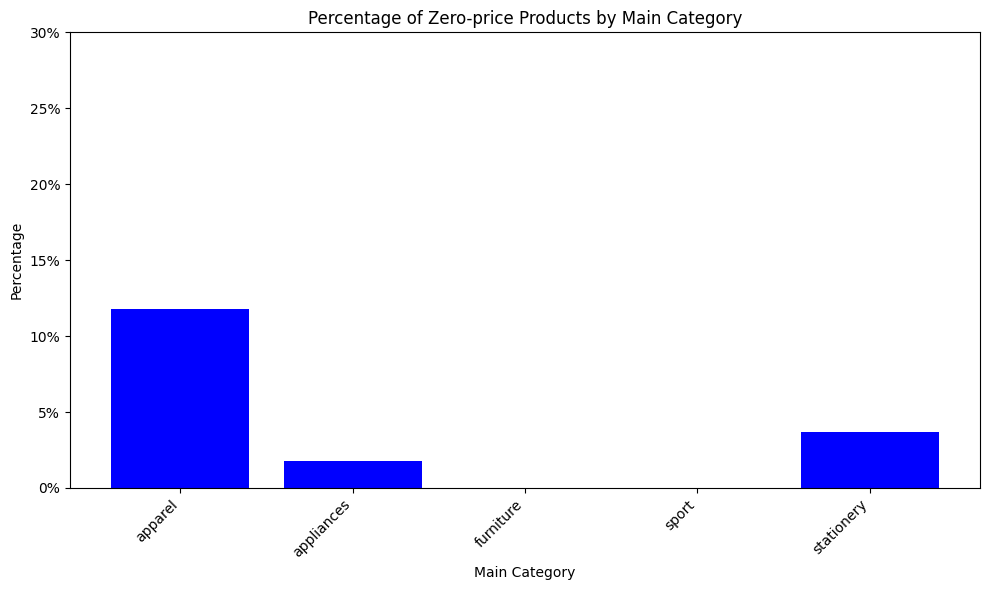

In [37]:
# Calculate the percentage of zero-price products by main category
percentage_zero_price = zeroprice_mainCat/mainCat_values * 100

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(percentage_zero_price.index, percentage_zero_price, color='blue')
plt.title('Percentage of Zero-price Products by Main Category')
plt.xlabel('Main Category')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 30)  # Set y-axis limit to 0-100 for percentage

# Format y-axis labels as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))

# Show the plot
plt.tight_layout()
plt.show()


In [38]:
# Donut chart of event_type
zeroprice_event_names = zero_price['event_type'].unique()
zeroprice_event_values = zero_price['event_type'].value_counts()
fig = px.pie(names=zeroprice_event_names, values=zeroprice_event_values, hole=0.3)
fig.update_layout({"title":{"text":"Distibution of zero-price product events", "x":0.50}})
fig.show()

In [39]:
data.head(10)

,event_time,event_type,product_id,category_id,main_category,sub_category,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
5,2019-10-01 00:00:16 UTC,cart,5857269,1487580005134238553,NaN,NaN,runail,2.62,430174032,73dea1e7-664e-43f4-8b30-d32b9d5af04f
6,2019-10-01 00:00:19 UTC,cart,5739055,1487580008246412266,NaN,NaN,kapous,4.75,377667011,81326ac6-daa4-4f0a-b488-fd0956a78733
7,2019-10-01 00:00:24 UTC,cart,5825598,1487580009445982239,NaN,NaN,NaN,0.56,467916806,2f5b5546-b8cb-9ee7-7ecd-84276f8ef486
8,2019-10-01 00:00:25 UTC,cart,5698989,1487580006317032337,NaN,NaN,NaN,1.27,385985999,d30965e8-1101-44ab-b45d-cc1bb9fae694
9,2019-10-01 00:00:26 UTC,view,5875317,2029082628195353599,NaN,NaN,NaN,1.59,474232307,445f2b74-5e4c-427e-b7fa-6e0a28b156fe


In [40]:
# # Some ids
# zeroprice_id = [5892084, 5892052, 5873432, 5882605]

# # Convert event_time to datetime format
# data['event_time'] = pd.to_datetime(data['event_time'])

# # Create subplots
# fig, axs = plt.subplots(len(zeroprice_id), 1, figsize=(10, 12), sharex=True)

# # Plot price history for each product
# for i, product_id in enumerate(zeroprice_id):
#     product_data = data[data['product_id'] == product_id]
#     axs[i].plot(product_data['event_time'], product_data['price'], marker='o', linestyle='-', color='b')
#     axs[i].set_title(f'Price History of Product ID {product_id}')
#     axs[i].set_ylabel('Price')
#     axs[i].grid(True)

# axs[len(zeroprice_id) - 1].set_xlabel('Event Time')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [41]:
zeroprice_products = data.groupby('product_id')
mean_price = zeroprice_products['price'].mean()
zeromean_price = mean_price[mean_price==0]
print(zeromean_price)
print('Number of products has zero price throughout the whole month: ', len(zeromean_price))

product_id
5837453    0.0
5837553    0.0
5837554    0.0
5864610    0.0
5870110    0.0
          ... 
5900459    0.0
5900460    0.0
5900461    0.0
5900462    0.0
5900464    0.0
Name: price, Length: 280, dtype: float64
Number of products has zero price throughout the whole month:  280


In [42]:
# def cleanBrand_test():
#     df = {
#         'product_id': [5773203, 5773353, 5881589, 5773353, 5723490, 5881449, 5857269, 5773203],
#         'brand': ['a', 'nan', 'c', 'b', 'd', 'd', 'nan', 'g']
#     }
#     df = pd.DataFrame(df)
#     print(df)

#     # Group by product_id and count distinct brands
#     product_brands_df = df.groupby('product_id')['brand'].unique().reset_index()
#     print(product_brands_df)

#     print(f'Found {len(product_brands_df[product_brands_df.brand.apply(lambda x: len(x) > 1)])} brand with multiple brands')

#     def clean_brand(brand_list):
#             for brand in brand_list:
#                 if brand and brand!='nan':
#                     return brand
#             return None

#     product_brands_df['brand'] = product_brands_df['brand'].apply(clean_brand)
#     print(product_brands_df)

#     df = df.merge(product_brands_df[['product_id', 'brand']], on='product_id', how='left', suffixes=('', '_new'))
#     print(df)
#     df['brand'] = df['brand_new'].fillna(df['brand'])
#     df.drop(columns=['brand_new'], inplace=True)
#     print(df)

# cleanBrand_test()

In [43]:
# Group by product_id and count distinct brands
num_brands = data.groupby('product_id')['brand'].nunique().sort_values(ascending=False).reset_index().iloc[0]['brand']
print(num_brands)

# In case the product has various brands throughout the period: fill the NaN with brand from this table
if int(num_brands)>1:

    product_brands = data.groupby('product_id')['brand'].unique().reset_index()

    print('------------------------------------------')
    print(f'Found {len(product_brands[product_brands.brand.apply(lambda x: len(x) > 1)])} brand with multiple brands...')
    print('------------------------------------------')

    # if brand has 2 brands, choose the one that is not null
    def clean_brand(brand_list):
        for brand in brand_list:
            if brand and brand!='nan':
                return brand
        return None

    product_brands['brand'] = product_brands['brand'].apply(clean_brand)

    def fill_brand(df, product_brands_df):
        df = df.merge(product_brands_df[['product_id', 'brand']], on='product_id', how='left', suffixes=('', '_new'))
        df['brand'] = df['brand_new'].fillna(df['brand'])
        df.drop(columns=['brand_new'], inplace=True)
        print('Filled successfully')

    fill_brand(data, product_brands)


1


In [44]:
num_brands = data['brand'].nunique()
print('Total number of brands: ', num_brands)

Total number of brands:  240


In [45]:
data

,event_time,event_type,product_id,category_id,main_category,sub_category,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
...,...,...,...,...,...,...,...,...,...,...
4102278,2019-10-31 23:59:25 UTC,remove_from_cart,5848062,1526733091857498510,NaN,NaN,NaN,9.21,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a
4102279,2019-10-31 23:59:30 UTC,view,5885631,1783999064103190764,NaN,NaN,NaN,15.48,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f
4102280,2019-10-31 23:59:34 UTC,view,5784898,1487580009143992338,NaN,NaN,NaN,1.78,564441099,8cbf1746-2d46-4169-afb1-b5fa38ee1ba4
4102281,2019-10-31 23:59:36 UTC,view,5870838,1487580007675986893,NaN,NaN,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a


## 1.3. Price and Brand

In [46]:
def drop_cart_duplicates(data):
    # Drop cart duplicates
    before_data = len(data)
    cart_data = data[data.event_type=='cart']
    # show duplicates
    #print(cart_data[cart_data.duplicated(subset=['product_id', 'user_id', 'user_session'], keep=False)].sort_values('user_id').head(10))
    cart_duplicates = len(cart_data[cart_data.duplicated(subset=['product_id', 'user_id', 'user_session'], keep=False)])
    print('Found {} duplicates'.format(cart_duplicates))

    data = data[data.event_type!='cart']
    cart_data.drop_duplicates(subset=['product_id', 'user_id', 'user_session'], keep='first', inplace=True)
    # check if exist duplicates
    #print(cart_data[cart_data.duplicated(subset=['product_id', 'user_id', 'user_session'], keep=False)].sort_values('user_id').head(10))

    # union
    data = pd.concat([cart_data, data])
    print('Data from {} rows reduced to {} rows'.format(before_data, len(data)))
    data.sort_values(by=['event_time'])

    return data

data = drop_cart_duplicates(data)
data.head(10)

Found 348863 duplicates


<ipython-input-46-a6c5051ed9c8>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Data from 3889128 rows reduced to 3667559 rows


,event_time,event_type,product_id,category_id,main_category,sub_category,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
5,2019-10-01 00:00:16 UTC,cart,5857269,1487580005134238553,NaN,NaN,runail,2.62,430174032,73dea1e7-664e-43f4-8b30-d32b9d5af04f
6,2019-10-01 00:00:19 UTC,cart,5739055,1487580008246412266,NaN,NaN,kapous,4.75,377667011,81326ac6-daa4-4f0a-b488-fd0956a78733
7,2019-10-01 00:00:24 UTC,cart,5825598,1487580009445982239,NaN,NaN,NaN,0.56,467916806,2f5b5546-b8cb-9ee7-7ecd-84276f8ef486
8,2019-10-01 00:00:25 UTC,cart,5698989,1487580006317032337,NaN,NaN,NaN,1.27,385985999,d30965e8-1101-44ab-b45d-cc1bb9fae694
16,2019-10-01 00:00:34 UTC,cart,5670337,1752742615205281895,NaN,NaN,NaN,2.38,546705258,3b5c65c0-bb1c-453b-b340-4ebf973a3136


In [47]:
def drop_removecart_duplicates(data):
    # Drop cart duplicates
    before_data = len(data)
    removecart_data = data[data.event_type=='remove_from_cart']
    # show duplicates
    #print(removecart_data[removecart_data.duplicated(subset=['product_id', 'user_id', 'user_session'], keep=False)].sort_values('user_id').head(10))
    removecart_duplicates = len(removecart_data[removecart_data.duplicated(subset=['product_id', 'user_id', 'user_session'], keep=False)])
    print('Found {} duplicates'.format(removecart_duplicates))

    data = data[data.event_type!='remove_from_cart']
    removecart_data.drop_duplicates(subset=['product_id', 'user_id', 'user_session'], keep='last', inplace=True)
    # check if exist duplicates
    #print(removecart_data[removecart_data.duplicated(subset=['product_id', 'user_id', 'user_session'], keep=False)].sort_values('user_id').head(10))

    # union
    data = pd.concat([data, removecart_data])
    print('Data from {} rows reduced to {} rows'.format(before_data, len(data)))

    data.sort_values(by=['event_time'])

    return data

data = drop_removecart_duplicates(data)
data.head(10)

Found 128702 duplicates


<ipython-input-47-1aebce65f078>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Data from 3667559 rows reduced to 3597348 rows


,event_time,event_type,product_id,category_id,main_category,sub_category,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
5,2019-10-01 00:00:16 UTC,cart,5857269,1487580005134238553,NaN,NaN,runail,2.62,430174032,73dea1e7-664e-43f4-8b30-d32b9d5af04f
6,2019-10-01 00:00:19 UTC,cart,5739055,1487580008246412266,NaN,NaN,kapous,4.75,377667011,81326ac6-daa4-4f0a-b488-fd0956a78733
7,2019-10-01 00:00:24 UTC,cart,5825598,1487580009445982239,NaN,NaN,NaN,0.56,467916806,2f5b5546-b8cb-9ee7-7ecd-84276f8ef486
8,2019-10-01 00:00:25 UTC,cart,5698989,1487580006317032337,NaN,NaN,NaN,1.27,385985999,d30965e8-1101-44ab-b45d-cc1bb9fae694
16,2019-10-01 00:00:34 UTC,cart,5670337,1752742615205281895,NaN,NaN,NaN,2.38,546705258,3b5c65c0-bb1c-453b-b340-4ebf973a3136


In [48]:
# Derive dataset for distinct products
data_product = data.drop_duplicates(subset='product_id')
data_product

,event_time,event_type,product_id,category_id,main_category,sub_category,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
...,...,...,...,...,...,...,...,...,...,...
4069171,2019-10-31 17:40:55 UTC,remove_from_cart,5556098,1487580007659209676,NaN,NaN,cnd,11.11,488043875,1fc42dca-e3bd-425b-9db0-5683c0ad7a41
4069202,2019-10-31 17:41:10 UTC,remove_from_cart,5867468,1487580004882580302,NaN,NaN,NaN,1.35,488043875,1fc42dca-e3bd-425b-9db0-5683c0ad7a41
4069208,2019-10-31 17:41:12 UTC,remove_from_cart,5867532,1487580005595612013,NaN,NaN,NaN,2.10,488043875,1fc42dca-e3bd-425b-9db0-5683c0ad7a41
4084745,2019-10-31 19:43:15 UTC,remove_from_cart,5848306,1487580005595612013,NaN,NaN,NaN,3.00,515625962,cecb8d26-0f85-4432-b3b6-2f5f576864f7


In [49]:
# Categorize products based on price ranges
bins = [0, 10, 100, 500, float('inf')]
labels = ['0-10 USD', '10-100 USD', '100-500 USD', 'Above 500 USD']
price_range_data = pd.cut(data_product['price'], bins=bins, labels=labels).reset_index()

# Count the number of products in each price range
price_range_counts = price_range_data['price'].value_counts().reset_index()
price_range_counts.columns = ['price', 'count']

# Create a donut chart using Plotly Express
fig = px.pie(price_range_counts, values='count', names='price', hole=0.3,
             labels={'price': 'Price Range'},
             title='Distribution of Products by Price Range')

# Show the donut chart
fig.show()

# Median price of each brand
median_price = data.groupby('brand')['price'].median().reset_index()
print(median_price)

          brand  price
0      airnails   1.43
1         almea  31.43
2        andrea   5.54
3        ardell   6.37
4    art-visage   2.94
..          ...    ...
235       ypsed  19.16
236        yu-r  39.68
237         zab  16.03
238      zeitun  10.87
239      zinger   4.60

[240 rows x 2 columns]


In [50]:
median_range_data = pd.cut(median_price['price'], bins=bins, labels=labels)

# Count the number of products in each price range
median_range_counts = median_range_data.value_counts()

# Create a donut chart using Plotly Express
fig = px.bar(data_frame=median_range_counts, x=median_range_counts,y=median_range_counts.index,
            orientation='h', labels={'x': 'Number of brands', 'y': 'Median Price Range'},
             title='Number of Brands by Median Price Range')

# Show the donut chart
fig.show()

The presence of a significant number of brands in the **100-500 USD** range suggests a consumer demand for mid-range products with advanced features (will have closer look on customer perspectives).

## 1.4. Event time

In this section, we are going to split **event_time** into **date** and **time**, also extract **weekday** from **date** feature for further customer behavior analysis:

In [51]:
def split_datetime(data):
    # Split into date and time
    data['event_time'] = pd.to_datetime(data['event_time'])
    data['date'] = pd.to_datetime(data['event_time'].dt.date)
    data['time'] = data['event_time'].dt.time
    data['weekday'] = data['date'].dt.weekday
    print('Splitted sucessfully')

    data.drop('event_time', axis='columns')
    data = data[['date', 'weekday', 'time', 'event_type', 'product_id', 'category_id', 'main_category', 'sub_category', 'brand', 'price', 'user_id', 'user_session']]
    print('Rearanged sucessfully')

    data.sort_values(by=['date', 'time'])
    data['date'] = pd.to_datetime(data['date'])

    return data

data = split_datetime(data)
data.head(10)

Splitted sucessfully
Rearanged sucessfully


<ipython-input-51-7972adc738cd>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,weekday,time,event_type,product_id,category_id,main_category,sub_category,brand,price,user_id,user_session
0,2019-10-01,1,00:00:00,cart,5773203,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01,1,00:00:03,cart,5773353,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01,1,00:00:07,cart,5881589,2151191071051219817,NaN,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01,1,00:00:07,cart,5723490,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01,1,00:00:15,cart,5881449,1487580013522845895,NaN,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
5,2019-10-01,1,00:00:16,cart,5857269,1487580005134238553,NaN,NaN,runail,2.62,430174032,73dea1e7-664e-43f4-8b30-d32b9d5af04f
6,2019-10-01,1,00:00:19,cart,5739055,1487580008246412266,NaN,NaN,kapous,4.75,377667011,81326ac6-daa4-4f0a-b488-fd0956a78733
7,2019-10-01,1,00:00:24,cart,5825598,1487580009445982239,NaN,NaN,NaN,0.56,467916806,2f5b5546-b8cb-9ee7-7ecd-84276f8ef486
8,2019-10-01,1,00:00:25,cart,5698989,1487580006317032337,NaN,NaN,NaN,1.27,385985999,d30965e8-1101-44ab-b45d-cc1bb9fae694
16,2019-10-01,1,00:00:34,cart,5670337,1752742615205281895,NaN,NaN,NaN,2.38,546705258,3b5c65c0-bb1c-453b-b340-4ebf973a3136


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3597348 entries, 0 to 4102278
Data columns (total 12 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   weekday        int32         
 2   time           object        
 3   event_type     object        
 4   product_id     int64         
 5   category_id    int64         
 6   main_category  object        
 7   sub_category   object        
 8   brand          object        
 9   price          float64       
 10  user_id        int64         
 11  user_session   object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), object(6)
memory usage: 343.1+ MB


In [53]:
# drop negative prices
def drop_neg_price(data):
    data = data.loc[data.price>=0]
    return data

data = drop_neg_price(data)

In [54]:
# check neg prices
data.loc[data.price<0]

,date,weekday,time,event_type,product_id,category_id,main_category,sub_category,brand,price,user_id,user_session


In [55]:
for i,j in data.groupby('category_id')['price']:
    print(i,j)
    break

1487580004832248652 2423        9.37
2434       14.13
2435       15.08
2437        9.37
2445        9.37
           ...  
4098608    14.13
4098644     9.37
4098647     9.37
4098650    12.71
4098651     9.37
Name: price, Length: 10995, dtype: float64


In [56]:
percentiles_IQR = data.groupby('category_id')['price'].quantile([0.25, 0.5, 0.75]).unstack().reset_index()
percentiles_IQR

,category_id,0.25,0.5,0.75
0,1487580004832248652,9.37,9.37,14.13
1,1487580004857414477,5.54,5.54,6.33
2,1487580004882580302,2.70,2.70,2.70
3,1487580004916134735,4.70,5.22,5.71
4,1487580004966466385,8.41,8.41,8.41
...,...,...,...,...
485,2195085255034011676,1.24,2.21,4.24
486,2195085255117897760,3.56,5.70,19.84
487,2195085255176618020,1.75,2.05,4.52
488,2195085258272014535,3.65,3.65,4.76


In [57]:
percentiles_IQR.rename(columns={0.25: 'Q1', 0.5: 'median', 0.75: 'Q3'}, inplace=True)
percentiles_IQR

,category_id,Q1,median,Q3
0,1487580004832248652,9.37,9.37,14.13
1,1487580004857414477,5.54,5.54,6.33
2,1487580004882580302,2.70,2.70,2.70
3,1487580004916134735,4.70,5.22,5.71
4,1487580004966466385,8.41,8.41,8.41
...,...,...,...,...
485,2195085255034011676,1.24,2.21,4.24
486,2195085255117897760,3.56,5.70,19.84
487,2195085255176618020,1.75,2.05,4.52
488,2195085258272014535,3.65,3.65,4.76


In [58]:
percentiles_IQR['IQR'] = percentiles_IQR['Q3'] - percentiles_IQR['Q1']
percentiles_IQR

,category_id,Q1,median,Q3,IQR
0,1487580004832248652,9.37,9.37,14.13,4.76
1,1487580004857414477,5.54,5.54,6.33,0.79
2,1487580004882580302,2.70,2.70,2.70,0.00
3,1487580004916134735,4.70,5.22,5.71,1.01
4,1487580004966466385,8.41,8.41,8.41,0.00
...,...,...,...,...,...
485,2195085255034011676,1.24,2.21,4.24,3.00
486,2195085255117897760,3.56,5.70,19.84,16.28
487,2195085255176618020,1.75,2.05,4.52,2.77
488,2195085258272014535,3.65,3.65,4.76,1.11


In [59]:
 data.merge(percentiles_IQR, on='category_id', how='left')

,date,weekday,time,event_type,product_id,category_id,main_category,sub_category,brand,price,user_id,user_session,Q1,median,Q3,IQR
0,2019-10-01,1,00:00:00,cart,5773203,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2.62,2.62,2.62,0.00
1,2019-10-01,1,00:00:03,cart,5773353,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2.62,2.62,2.62,0.00
2,2019-10-01,1,00:00:07,cart,5881589,2151191071051219817,NaN,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,3.81,5.56,7.94,4.13
3,2019-10-01,1,00:00:07,cart,5723490,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2.62,2.62,2.62,0.00
4,2019-10-01,1,00:00:15,cart,5881449,1487580013522845895,NaN,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,1.11,4.13,7.78,6.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3597323,2019-10-31,3,23:56:57,remove_from_cart,5826183,1487580007483048900,NaN,NaN,NaN,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,2.06,3.33,3.97,1.91
3597324,2019-10-31,3,23:57:02,remove_from_cart,5835924,1487580009471148064,NaN,NaN,irisk,1.51,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,0.32,1.19,1.75,1.43
3597325,2019-10-31,3,23:58:49,remove_from_cart,5870822,1487580007675986893,NaN,NaN,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,0.79,1.27,1.59,0.80
3597326,2019-10-31,3,23:59:08,remove_from_cart,5747404,1487580005671109489,NaN,NaN,masura,6.33,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,1.73,2.37,2.84,1.11


In [60]:
data

,date,weekday,time,event_type,product_id,category_id,main_category,sub_category,brand,price,user_id,user_session
0,2019-10-01,1,00:00:00,cart,5773203,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01,1,00:00:03,cart,5773353,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01,1,00:00:07,cart,5881589,2151191071051219817,NaN,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01,1,00:00:07,cart,5723490,1487580005134238553,NaN,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01,1,00:00:15,cart,5881449,1487580013522845895,NaN,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
...,...,...,...,...,...,...,...,...,...,...,...,...
4102253,2019-10-31,3,23:56:57,remove_from_cart,5826183,1487580007483048900,NaN,NaN,NaN,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
4102256,2019-10-31,3,23:57:02,remove_from_cart,5835924,1487580009471148064,NaN,NaN,irisk,1.51,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
4102272,2019-10-31,3,23:58:49,remove_from_cart,5870822,1487580007675986893,NaN,NaN,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a
4102275,2019-10-31,3,23:59:08,remove_from_cart,5747404,1487580005671109489,NaN,NaN,masura,6.33,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a


In [61]:
def relative_price(data):
    print('Calculating relative price...')

    start = time.time()
    # calculate percentiles_IQR
    percentiles_IQR = data.groupby('category_id')['price'].quantile([0.25, 0.5, 0.75]).unstack().reset_index()
    percentiles_IQR.rename(columns={0.25: 'Q1', 0.5: 'median', 0.75: 'Q3'}, inplace=True)
    percentiles_IQR['IQR'] = percentiles_IQR['Q3'] - percentiles_IQR['Q1']


    # calculate relative price by price-median/IQR
    data = data.merge(percentiles_IQR, on='category_id', how='left')
    data['relative_price'] = np.where(data['IQR']==0, 0, (data['price']-data['median'])/data['IQR'])
    data['relative_price'] = data['relative_price'].apply(lambda x: max(min(x, 10), -10))  # avoid exceeding
    data.drop(columns=['Q1', 'Q3', 'median', 'IQR'], axis='columns',inplace=True)
    end = time.time()

    # rearrange
    data = data[['date', 'weekday', 'time', 'event_type', 'product_id', 'category_id', 'main_category', 'sub_category',
                'brand', 'price', 'relative_price', 'user_id', 'user_session']]
    print('Finished in {0:.3f}s'.format(end-start))
    return data

data = relative_price(data)
data.describe()

Calculating relative price...
Finished in 4.505s


,date,weekday,product_id,category_id,price,relative_price,user_id
count,3597328,3.597328e+06,3.597328e+06,3.597328e+06,3.597328e+06,3.597328e+06,3.597328e+06
mean,2019-10-15 16:25:49.686212096,2.772886e+00,5.465313e+06,1.545429e+18,8.990314e+00,2.618337e-01,5.008533e+08
min,2019-10-01 00:00:00,0.000000e+00,3.752000e+03,1.487580e+18,0.000000e+00,-1.000000e+01,4.103071e+06
25%,2019-10-08 00:00:00,1.000000e+00,5.723503e+06,1.487580e+18,2.370000e+00,-2.059369e-01,4.687971e+08
50%,2019-10-16 00:00:00,3.000000e+00,5.809218e+06,1.487580e+18,4.220000e+00,0.000000e+00,5.385138e+08
75%,2019-10-23 00:00:00,4.000000e+00,5.850626e+06,1.487580e+18,7.220000e+00,3.950617e-01,5.576057e+08
max,2019-10-31 00:00:00,6.000000e+00,5.900470e+06,2.195085e+18,3.076000e+02,1.000000e+01,5.662808e+08
std,NaN,1.946518e+00,1.328695e+06,1.560948e+17,2.000007e+01,1.292298e+00,8.228283e+07


In [62]:
data.isna().sum()

,0
date,0
weekday,0
time,0
event_type,0
product_id,0
category_id,0
main_category,3536227
sub_category,3536227
brand,1451963
price,0


In [63]:
data

,date,weekday,time,event_type,product_id,category_id,main_category,sub_category,brand,price,relative_price,user_id,user_session
0,2019-10-01,1,00:00:00,cart,5773203,1487580005134238553,NaN,NaN,runail,2.62,0.000000,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01,1,00:00:03,cart,5773353,1487580005134238553,NaN,NaN,runail,2.62,0.000000,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01,1,00:00:07,cart,5881589,2151191071051219817,NaN,NaN,lovely,13.48,1.917676,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01,1,00:00:07,cart,5723490,1487580005134238553,NaN,NaN,runail,2.62,0.000000,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01,1,00:00:15,cart,5881449,1487580013522845895,NaN,NaN,lovely,0.56,-0.535232,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3597323,2019-10-31,3,23:56:57,remove_from_cart,5826183,1487580007483048900,NaN,NaN,NaN,3.33,0.000000,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
3597324,2019-10-31,3,23:57:02,remove_from_cart,5835924,1487580009471148064,NaN,NaN,irisk,1.51,0.223776,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
3597325,2019-10-31,3,23:58:49,remove_from_cart,5870822,1487580007675986893,NaN,NaN,milv,0.79,-0.600000,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a
3597326,2019-10-31,3,23:59:08,remove_from_cart,5747404,1487580005671109489,NaN,NaN,masura,6.33,3.567568,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a


In [64]:
clean_name = f'{name}-clean'
#data.to_csv(f'{input_path}\\clean\\{clean_name}.csv')

# 2. Feature Engineering

Create 2 tables: product and user tables for futher recommendation system

In [65]:
def merge_dataframe(list_data, on=None, suffixes=('_x', '_y')):

	df_merge = list_data[0]
	for df in list_data[1:]:
		df_merge = df_merge.merge(df, on=on, how='left', suffixes=suffixes)

	return df_merge

## 2.1. Product table

In [66]:
def create_productTable(data):

	start = time.time()
	# feature engineering
	print('Basic features processing...')
	productTable = data.groupby('product_id').agg(
		first_date=('date', 'min'),
		last_date=('date', 'max'),
		category_id=('category_id', 'first'),
		avg_price=('price', 'mean'),
		relative_price=('relative_price', 'mean'),
		views=('event_type', lambda x: (x == 'view').sum()),
		carts=('event_type', lambda x: (x == 'cart').sum()),
		remove_from_carts=('event_type', lambda x: (x == 'remove_from_cart').sum()),
		purchases=('event_type', lambda x: (x == 'purchase').sum()),
	).reset_index()

	print('Interaction rates processing...')
	# calculate rate
	productTable['cart_per_view'] = 100*np.where(productTable['views'] == 0, productTable['carts'], productTable['carts']/productTable['views'])
	productTable['purchase_per_view'] = 100*np.where(productTable['views'] == 0, productTable['purchases'], productTable['purchases']/productTable['views'])
	productTable['remove_per_cart'] = 100*np.where(productTable['carts'] == 0, productTable['remove_from_carts'], productTable['remove_from_carts']/productTable['carts'])
	productTable['purchase_per_cart'] = 100*np.where(productTable['carts'] == 0, productTable['purchases'], productTable['purchases']/productTable['carts'])

	# by weighted mean
	total_views = productTable[['views']].sum().sum()
	total_carts = productTable[['carts']].sum().sum()
	total_removes = productTable[['remove_from_carts']].sum().sum()
	total_purchases = productTable[['purchases']].sum().sum()

	# rate by weights
	productTable['cart_per_view'] = productTable['cart_per_view']\
			*(productTable['views']/total_views)
	productTable['purchase_per_view'] = productTable['purchase_per_view']\
			*(productTable['views']/total_views)
	productTable['remove_per_cart'] = productTable['remove_per_cart']\
			*((productTable['carts'])/total_carts)
	productTable['purchase_per_cart'] = productTable['purchase_per_cart']\
			*((productTable['carts'])/total_carts)

	# normalize rates by min-max
	rate_columns = ['cart_per_view', 'purchase_per_view', 'remove_per_cart', 'purchase_per_cart']
	for col in rate_columns:
		min_value = productTable[col].min()
		max_value = productTable[col].max()
		productTable[col] = (productTable[col] - min_value) / (max_value - min_value)
	end = time.time()

	print('Create product table success. Finish in {0:.3f}s'.format(end-start))
	return productTable

productTable = create_productTable(data)
productTable

Basic features processing...
Interaction rates processing...
Create product table success. Finish in 19.719s


,product_id,first_date,last_date,category_id,avg_price,relative_price,views,carts,remove_from_carts,purchases,cart_per_view,purchase_per_view,remove_per_cart,purchase_per_cart
0,3752,2019-10-01,2019-10-31,1487580005411062629,15.71,-0.200000,14,0,0,0,0.000000,0.000000,0.000000,0.000000
1,3762,2019-10-01,2019-10-31,1487580005411062629,19.37,2.087500,387,171,77,50,0.089764,0.071429,0.092326,0.071429
2,3763,2019-10-01,2019-10-31,1487580005411062629,16.03,0.000000,97,27,13,8,0.014173,0.011429,0.015588,0.011429
3,3771,2019-10-08,2019-10-29,1487580005411062629,15.08,-0.593750,6,0,0,0,0.000000,0.000000,0.000000,0.000000
4,3774,2019-10-01,2019-10-31,1487580005411062629,16.03,0.000000,129,62,28,25,0.032546,0.035714,0.033573,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41889,5900462,2019-10-31,2019-10-31,1487580013749338323,0.00,-3.893082,1,0,0,0,0.000000,0.000000,0.000000,0.000000
41890,5900464,2019-10-31,2019-10-31,1487580008246412266,0.00,-1.067204,1,0,0,0,0.000000,0.000000,0.000000,0.000000
41891,5900467,2019-10-31,2019-10-31,2151191071378375538,4.76,-0.347707,0,1,0,0,0.000000,0.000000,0.000000,0.000000
41892,5900469,2019-10-31,2019-10-31,2151191071378375538,4.76,-0.347707,0,1,0,0,0.000000,0.000000,0.000000,0.000000


In [67]:
productTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41894 entries, 0 to 41893
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   product_id         41894 non-null  int64         
 1   first_date         41894 non-null  datetime64[ns]
 2   last_date          41894 non-null  datetime64[ns]
 3   category_id        41894 non-null  int64         
 4   avg_price          41894 non-null  float64       
 5   relative_price     41894 non-null  float64       
 6   views              41894 non-null  int64         
 7   carts              41894 non-null  int64         
 8   remove_from_carts  41894 non-null  int64         
 9   purchases          41894 non-null  int64         
 10  cart_per_view      41894 non-null  float64       
 11  purchase_per_view  41894 non-null  float64       
 12  remove_per_cart    41894 non-null  float64       
 13  purchase_per_cart  41894 non-null  float64       
dtypes: dat

In [68]:
productTable.describe()

,product_id,first_date,last_date,category_id,avg_price,relative_price,views,carts,remove_from_carts,purchases,cart_per_view,purchase_per_view,remove_per_cart,purchase_per_cart
count,4.189400e+04,41894,41894,4.189400e+04,41894.000000,41894.000000,41894.000000,41894.000000,41894.000000,41894.000000,41894.000000,41894.000000,41894.000000,41894.000000
mean,5.533471e+06,2019-10-03 18:18:30.574306560,2019-10-27 15:31:35.813243136,1.569743e+18,7.574609,0.452792,44.446699,23.455602,12.110756,5.854323,0.012308,0.008360,0.014458,0.008363
min,3.752000e+03,2019-10-01 00:00:00,2019-10-01 00:00:00,1.487580e+18,0.000000,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.742414e+06,2019-10-01 00:00:00,2019-10-28 00:00:00,1.487580e+18,2.780000,-0.128521,5.000000,3.000000,1.000000,0.000000,0.001575,0.000000,0.001199,0.000000
50%,5.819258e+06,2019-10-01 00:00:00,2019-10-30 00:00:00,1.487580e+18,4.700000,0.000000,14.000000,8.000000,4.000000,1.000000,0.004199,0.001429,0.004796,0.001429
75%,5.858024e+06,2019-10-02 00:00:00,2019-10-31 00:00:00,1.487580e+18,7.780000,0.663866,37.000000,21.000000,12.000000,5.000000,0.011024,0.007143,0.014388,0.007143
max,5.900470e+06,2019-10-31 00:00:00,2019-10-31 00:00:00,2.195085e+18,307.600000,10.000000,9013.000000,1905.000000,834.000000,700.000000,1.000000,1.000000,1.000000,1.000000
std,1.215291e+06,NaN,NaN,1.756316e+17,11.711710,1.667722,149.575513,60.259567,28.561078,18.780928,0.031634,0.026831,0.034268,0.026830


In [69]:
product_name = f'{name}-product'
#data.to_csv(f'{input_path}\\clean\\{product_name}.csv')

In [70]:
productTable

,product_id,first_date,last_date,category_id,avg_price,relative_price,views,carts,remove_from_carts,purchases,cart_per_view,purchase_per_view,remove_per_cart,purchase_per_cart
0,3752,2019-10-01,2019-10-31,1487580005411062629,15.71,-0.200000,14,0,0,0,0.000000,0.000000,0.000000,0.000000
1,3762,2019-10-01,2019-10-31,1487580005411062629,19.37,2.087500,387,171,77,50,0.089764,0.071429,0.092326,0.071429
2,3763,2019-10-01,2019-10-31,1487580005411062629,16.03,0.000000,97,27,13,8,0.014173,0.011429,0.015588,0.011429
3,3771,2019-10-08,2019-10-29,1487580005411062629,15.08,-0.593750,6,0,0,0,0.000000,0.000000,0.000000,0.000000
4,3774,2019-10-01,2019-10-31,1487580005411062629,16.03,0.000000,129,62,28,25,0.032546,0.035714,0.033573,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41889,5900462,2019-10-31,2019-10-31,1487580013749338323,0.00,-3.893082,1,0,0,0,0.000000,0.000000,0.000000,0.000000
41890,5900464,2019-10-31,2019-10-31,1487580008246412266,0.00,-1.067204,1,0,0,0,0.000000,0.000000,0.000000,0.000000
41891,5900467,2019-10-31,2019-10-31,2151191071378375538,4.76,-0.347707,0,1,0,0,0.000000,0.000000,0.000000,0.000000
41892,5900469,2019-10-31,2019-10-31,2151191071378375538,4.76,-0.347707,0,1,0,0,0.000000,0.000000,0.000000,0.000000


## 2.1. User table

In [71]:
def create_userInteraction(data):
    # count events
    views = data.loc[data.event_type=='view'].groupby('user_id').event_type.count().reset_index()
    views.rename(columns={'event_type': 'views'}, inplace=True)
    carts = data.loc[data.event_type=='cart'].groupby('user_id').event_type.count().reset_index()
    carts.rename(columns={'event_type': 'carts'}, inplace=True)
    removes = data.loc[data.event_type=='remove_from_cart'].groupby('user_id').event_type.count().reset_index()
    removes.rename(columns={'event_type': 'remove_from_carts'}, inplace=True)
    purchases = data.loc[data.event_type=='purchase'].groupby('user_id').event_type.count().reset_index()
    purchases.rename(columns={'event_type': 'purchases'}, inplace=True)
    sumEvent_mask = merge_dataframe([views, carts, removes, purchases], on='user_id')
    sumEvent_mask.fillna(0, inplace=True)

    # average price
    viewPrice_mask = data.loc[data.event_type=='view'].groupby(['user_id']).price.mean().reset_index()
    viewPrice_mask.rename(columns={'price': 'avg_view_price'}, inplace=True)
    purchasePrice_mask = data.loc[data.event_type=='cart'].groupby(['user_id']).price.mean().reset_index()
    purchasePrice_mask.rename(columns={'price': 'avg_purchase_price'}, inplace=True)
    avgPrice_mask = merge_dataframe([viewPrice_mask, purchasePrice_mask], on='user_id')
    avgPrice_mask.fillna(0, inplace=True)

    # average price
    viewRelative_mask = data.loc[data.event_type=='view'].groupby(['user_id']).relative_price.mean().reset_index()
    viewRelative_mask.rename(columns={'relative_price': 'avg_view_relative_price'}, inplace=True)
    purchaseRelative_mask = data.loc[data.event_type=='cart'].groupby(['user_id']).relative_price.mean().reset_index()
    purchaseRelative_mask.rename(columns={'relative_price': 'avg_purchase_relative_price'}, inplace=True)
    avgRelative_mask = merge_dataframe([viewRelative_mask, purchaseRelative_mask], on='user_id')
    avgRelative_mask.fillna(0, inplace=True)

    # distinct product counts by event
    viewCount_mask = data.loc[data.event_type=='view'].groupby(['user_id']).product_id.nunique().reset_index()
    viewCount_mask.rename(columns={'product_id': 'distinct_view_product'}, inplace=True)
    cartCount_mask = data.loc[data.event_type=='cart'].groupby(['user_id']).product_id.nunique().reset_index()
    cartCount_mask.rename(columns={'product_id': 'distinct_cart_product'}, inplace=True)
    removeCount_mask = data.loc[data.event_type=='remove_from_cart'].groupby(['user_id']).product_id.nunique().reset_index()
    removeCount_mask.rename(columns={'product_id': 'distinct_remove_product'}, inplace=True)
    purchaseCount_mask = data.loc[data.event_type=='purchase'].groupby(['user_id']).product_id.nunique().reset_index()
    purchaseCount_mask.rename(columns={'product_id': 'distinct_purchase_product'}, inplace=True)
    eventCount_mask = merge_dataframe([viewCount_mask, cartCount_mask, removeCount_mask, purchaseCount_mask], on='user_id')
    eventCount_mask.fillna(0, inplace=True)

    return merge_dataframe([sumEvent_mask, avgPrice_mask, avgRelative_mask, eventCount_mask,], on='user_id')

#df = create_userInteraction(data)
#df

In [72]:
# create user table
def create_userTable(data):
	start = time.time()
	# feature engineering
	print('Basic features processing...')
	userTable = data.groupby('user_id').agg(
		first_date=('date', 'min'),
		last_date=('date', 'max'),
	).reset_index()

	userTable['first_date'] = pd.to_datetime(userTable['first_date'])
	userTable['last_date'] = pd.to_datetime(userTable['last_date'])

	print('Interaction features processing...')
	# create event features
	userTable = merge_dataframe([userTable, create_userInteraction(data)], on='user_id')

	print('Interaction rates processing...')
	# calculate rate
	userTable['cart_per_view'] = 100*np.where(userTable['views'] == 0, userTable['carts'], userTable['carts']/userTable['views'])
	userTable['purchase_per_view'] = 100*np.where(userTable['views'] == 0, userTable['purchases'], userTable['purchases']/userTable['views'])
	userTable['remove_per_cart'] = 100*np.where(userTable['carts'] == 0, userTable['remove_from_carts'], userTable['remove_from_carts']/userTable['carts'])
	userTable['purchase_per_cart'] = 100*np.where(userTable['carts'] == 0, userTable['purchases'], userTable['purchases']/userTable['carts'])
	userTable.fillna(0, inplace=True)

	# by weighted mean
	total_views = userTable[['views']].sum().sum()
	total_carts = userTable[['carts']].sum().sum()
	total_removes = userTable[['remove_from_carts']].sum().sum()
	total_purchases = userTable[['purchases']].sum().sum()

	# rate by weights
	userTable['cart_per_view'] = userTable['cart_per_view']\
			*(userTable['views']/total_views)
	userTable['purchase_per_view'] = userTable['purchase_per_view']\
			*(userTable['views']/total_views)
	userTable['remove_per_cart'] = userTable['remove_per_cart']\
			*((userTable['carts'])/total_carts)
	userTable['purchase_per_cart'] = userTable['purchase_per_cart']\
			*((userTable['carts'])/total_carts)

	# normalize rates by min-max
	rate_columns = ['cart_per_view', 'purchase_per_view', 'remove_per_cart', 'purchase_per_cart']
	for col in rate_columns:
		min_value = userTable[col].min()
		max_value = userTable[col].max()
		userTable[col] = (userTable[col] - min_value) / (max_value - min_value)

	# change type
	print('Check datatypes processing...')
	columns = userTable.columns
	userTable_type = ['int64', 'date', 'date',
		   			'int64', 'int64', 'int64', 'int64',
		   			'float', 'float', 'float', 'float',
					'int64', 'int64', 'int64', 'int64',
					'float', 'float', 'float', 'float']
	for i, col in enumerate(columns):
		if i in [1,2]: pass # i change date already
		else: userTable[col] = userTable[col].astype(userTable_type[i])

	end = time.time()
	print('Create user table success. Finish in {0:.3f}s'.format(end-start))
	return userTable

userTable = create_userTable(data)
userTable

Basic features processing...
Interaction features processing...
Interaction rates processing...
Check datatypes processing...
Create user table success. Finish in 7.367s


,user_id,first_date,last_date,views,carts,remove_from_carts,purchases,avg_view_price,avg_purchase_price,avg_view_relative_price,avg_purchase_relative_price,distinct_view_product,distinct_cart_product,distinct_remove_product,distinct_purchase_product,cart_per_view,purchase_per_view,remove_per_cart,purchase_per_cart
0,4103071,2019-10-21,2019-10-21,7,1,0,0,3.194286,0.670000,0.299074,-0.305118,6,1,0,0,0.000954,0.0,0.000000,0.0
1,8846226,2019-10-01,2019-10-02,7,24,12,0,5.628571,3.646250,0.073433,-0.135630,6,24,12,0,0.022901,0.0,0.009252,0.0
2,9794320,2019-10-01,2019-10-23,3,2,3,0,0.940000,1.015000,-0.677019,-0.670364,2,2,3,0,0.001908,0.0,0.002313,0.0
3,10280338,2019-10-21,2019-10-27,26,24,24,0,6.397692,5.100417,0.115385,0.086250,22,23,24,0,0.022901,0.0,0.018504,0.0
4,10702733,2019-10-15,2019-10-15,2,0,0,0,5.790000,0.000000,2.468750,0.000000,2,0,0,0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399659,566279639,2019-10-31,2019-10-31,1,0,0,0,10.950000,0.000000,0.000000,0.000000,1,0,0,0,0.000000,0.0,0.000000,0.0
399660,566279883,2019-10-31,2019-10-31,1,0,0,0,57.940000,0.000000,0.343897,0.000000,1,0,0,0,0.000000,0.0,0.000000,0.0
399661,566279996,2019-10-31,2019-10-31,1,0,0,0,9.370000,0.000000,0.116152,0.000000,1,0,0,0,0.000000,0.0,0.000000,0.0
399662,566280278,2019-10-31,2019-10-31,2,2,0,0,4.360000,1.730000,-0.361404,-0.576577,2,2,0,0,0.001908,0.0,0.000000,0.0


In [73]:
userTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399664 entries, 0 to 399663
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      399664 non-null  int64         
 1   first_date                   399664 non-null  datetime64[ns]
 2   last_date                    399664 non-null  datetime64[ns]
 3   views                        399664 non-null  int64         
 4   carts                        399664 non-null  int64         
 5   remove_from_carts            399664 non-null  int64         
 6   purchases                    399664 non-null  int64         
 7   avg_view_price               399664 non-null  float64       
 8   avg_purchase_price           399664 non-null  float64       
 9   avg_view_relative_price      399664 non-null  float64       
 10  avg_purchase_relative_price  399664 non-null  float64       
 11  distinct_view_product     

In [74]:
userTable.describe()

,user_id,first_date,last_date,views,carts,remove_from_carts,purchases,avg_view_price,avg_purchase_price,avg_view_relative_price,avg_purchase_relative_price,distinct_view_product,distinct_cart_product,distinct_remove_product,distinct_purchase_product,cart_per_view,purchase_per_view,remove_per_cart,purchase_per_cart
count,3.996640e+05,399664,399664,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000
mean,5.288604e+08,2019-10-13 19:56:21.584531456,2019-10-15 11:40:28.295768832,4.659039,2.328348,1.228752,0.585559,15.593047,2.464313,0.487741,0.105710,3.510254,2.218351,1.173861,0.571135,0.002222,0.001780,0.000936,0.001772
min,4.103071e+06,2019-10-01 00:00:00,2019-10-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000,-8.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.295908e+08,2019-10-06 00:00:00,2019-10-07 00:00:00,1.000000,0.000000,0.000000,0.000000,3.546198,0.000000,-0.106413,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.571228e+08,2019-10-13 00:00:00,2019-10-15 00:00:00,1.000000,0.000000,0.000000,0.000000,6.300000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.607882e+08,2019-10-22 00:00:00,2019-10-24 00:00:00,3.000000,1.000000,0.000000,0.000000,13.970000,2.620000,0.663866,0.000000,2.000000,1.000000,0.000000,0.000000,0.000954,0.000000,0.000000,0.000000
max,5.662808e+08,2019-10-31 00:00:00,2019-10-31 00:00:00,3086.000000,1048.000000,1297.000000,329.000000,307.600000,299.810000,10.000000,10.000000,1102.000000,1047.000000,1128.000000,327.000000,1.000000,1.000000,1.000000,1.000000
std,6.374482e+07,NaN,NaN,17.694462,11.030700,8.415544,3.647920,28.567443,8.567858,1.460932,0.701179,11.317503,10.146840,7.678078,3.512664,0.010525,0.011088,0.006480,0.011075


In [75]:
user_name = f'{name}-user'
#data.to_csv(f'{input_path}\\clean\\{user_name}.csv')

# 3. Recommendation System

## 3.1. Interaction Matrix

In collaborative filtering, it will based on the past interaction of user and of similar users to give recommended items. We need 3 main matrix:

1. User matrix: containing user content

2. Product matrix: contains product information

3. Interation matrix: display the interaction score (e.g. ratings) of all users toward every available products.

Alternating Least Squares algorithm is one approach to collaborative filtering that can be used to train a model on this interaction matrix. We will derive the interaction matrix based on recency combined with weight decay. Recent interactions are often more indicative of a user's current preferences than older interactions. In this case, we will intialize the interval recency for interaction matrix as 15 days (half-month) and weight decay to be 0.5 for this interval.

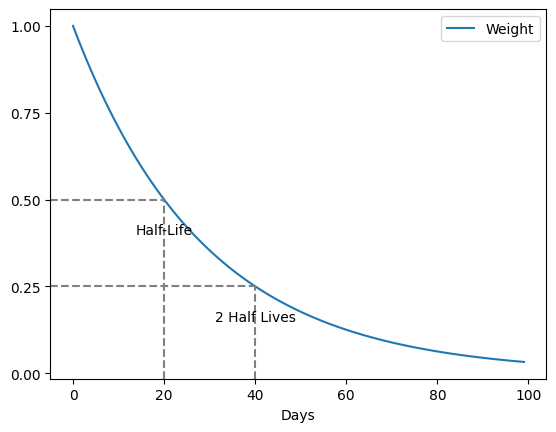

In [76]:
# Plot the half-life decay function

half_life = 20
x = np.arange(0, 100)
y = np.power(0.5, x / half_life)
df = pd.DataFrame({'Days': x, 'Weight': y})

# Plot the function
ax = df.plot(x='Days', y='Weight')

# Add vertical lines at 20 and 40 days with explanatory text
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.axvline(x=20, linestyle='--', color='gray', ymax=0.49)
ax.axvline(x=40, linestyle='--', color='gray', ymax=0.25)
ax.axhline(y=0.5, linestyle='--', color='gray', xmax=0.23)
ax.axhline(y=0.25, linestyle='--', color='gray', xmax=0.41)
ax.text(20, 0.4, 'Half-Life', ha='center')
ax.text(40, 0.15, '2 Half Lives', ha='center')

plt.show()

In [77]:
def calculate_recency(data):
    # Get the timestamp of the most recent event in the data_rec
    data_rec = data.copy()
    last_date = data_rec['date'].max()
    recency_days = 15
    weight_decay = 0.5

    # Calculate the recency of each event in terms of days
    data_rec['recency'] = (last_date - data_rec['date']).dt.total_seconds() / (24 * 60 * 60)

    # Half-life decay function, the value of an event with weight_decay after recency_days days
    data_rec['recency_coef'] = np.exp(np.log(weight_decay) * data_rec['recency'] / recency_days)

    # Drop the 'date' column if needed for real-time system
    data_rec.drop(columns=['date', 'time'], inplace=True)

    return data_rec

data_rec = calculate_recency(data)

In [78]:
data_rec

,weekday,event_type,product_id,category_id,main_category,sub_category,brand,price,relative_price,user_id,user_session,recency,recency_coef
0,1,cart,5773203,1487580005134238553,NaN,NaN,runail,2.62,0.000000,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,30.0,0.25
1,1,cart,5773353,1487580005134238553,NaN,NaN,runail,2.62,0.000000,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,30.0,0.25
2,1,cart,5881589,2151191071051219817,NaN,NaN,lovely,13.48,1.917676,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,30.0,0.25
3,1,cart,5723490,1487580005134238553,NaN,NaN,runail,2.62,0.000000,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,30.0,0.25
4,1,cart,5881449,1487580013522845895,NaN,NaN,lovely,0.56,-0.535232,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,30.0,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3597323,3,remove_from_cart,5826183,1487580007483048900,NaN,NaN,NaN,3.33,0.000000,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,0.0,1.00
3597324,3,remove_from_cart,5835924,1487580009471148064,NaN,NaN,irisk,1.51,0.223776,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,0.0,1.00
3597325,3,remove_from_cart,5870822,1487580007675986893,NaN,NaN,milv,0.79,-0.600000,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,0.0,1.00
3597326,3,remove_from_cart,5747404,1487580005671109489,NaN,NaN,masura,6.33,3.567568,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,0.0,1.00


In [79]:
# # initial dataframe
# interactionTable = pd.DataFrame(columns=['user_id', 'product_id'])
# interactionTable.user_id = data_rec.user_id
# interactionTable.product_id = data_rec.product_id
# interactionTable.drop_duplicates(inplace=True)

In [80]:
# interactionTable

In [81]:
# event_names = ['view', 'cart', 'remove_from_cart', 'purchase']
# event_names

In [82]:
# view_weight=0.1
# cart_weight=0.4
# remove_from_cart_weight=-0.3
# purchase_weight=1.0

In [83]:
# event_weights = [view_weight, cart_weight, remove_from_cart_weight, purchase_weight]
# event_weights

In [84]:
# data_rec

In [85]:
# df = data_rec.loc[data_rec['event_type']=='view'].groupby(['user_id', 'product_id']).recency_coef.sum().reset_index()

In [86]:
# df.rename(columns={'recency_coef': f'{name}s'}, inplace=True)

In [87]:
# df

In [88]:
# interactionTable = merge_dataframe([interactionTable, df], on=['user_id', 'product_id'])

In [89]:
# interactionTable

In [90]:
# interactionTable.isna().sum()

In [91]:
# interactionTable.fillna(value=0, inplace=True)
# interactionTable.isna().sum()

In [92]:
# interactionTable['interaction_score'] = 0
# interactionTable

In [93]:
# for weight, name in zip(event_weights, event_names):
#               print(weight,name)
#               break

In [94]:
# for weight, name in zip(event_weights, event_names):
#     interactionTable['interaction_score'] += weight*interactionTable[f'{name}s']
#     print(interactionTable)

In [95]:
#  # fill NaN with 0 (0 interaction score)
# interactionTable.fillna(value=0, inplace=True)

# print('Calculating interaction scores...')
# # calculate the interaction overall score for user-product pair by weight
# interactionTable['interaction_score'] = 0
# for weight, name in zip(event_weights, event_names):
#     interactionTable['interaction_score'] += weight*interactionTable[f'{name}s']

# interactionTable['interaction_score'] = interactionTable['interaction_score'].apply(lambda x: max(0,x))
# interactionTable['interaction_score'] = interactionTable['interaction_score'].apply(lambda x: min(100,x))

# interactionTable.sort_values(by='interaction_score', ascending=False, inplace=True)


In [96]:
def create_interactionTable(data, view_weight=0.1, cart_weight=0.4, remove_from_cart_weight=-0.3, purchase_weight=1.0):

    start = time.time()

    print('Calculating basic interactions...')
    # initial dataframe
    interactionTable = pd.DataFrame(columns=['user_id', 'product_id'])
    interactionTable.user_id = data.user_id
    interactionTable.product_id = data.product_id
    interactionTable.drop_duplicates(inplace=True)

    # for every event, calculate the interaction score for each user-product pair
    event_names = ['view', 'cart', 'remove_from_cart', 'purchase']
    event_weights = [view_weight, cart_weight, remove_from_cart_weight, purchase_weight]
    for name in event_names:
        df = data.loc[data['event_type']==name].groupby(['user_id', 'product_id']).recency_coef.sum().reset_index()
        df.rename(columns={'recency_coef': f'{name}s'}, inplace=True)
        interactionTable = merge_dataframe([interactionTable, df], on=['user_id', 'product_id'])

    # fill NaN with 0 (0 interaction score)
    interactionTable.fillna(value=0, inplace=True)

    print('Calculating interaction scores...')
    # calculate the interaction overall score for user-product pair by weight
    interactionTable['interaction_score'] = 0
    for weight, name in zip(event_weights, event_names):
        interactionTable['interaction_score'] += weight*interactionTable[f'{name}s']

    interactionTable['interaction_score'] = interactionTable['interaction_score'].apply(lambda x: max(0,x))
    interactionTable['interaction_score'] = interactionTable['interaction_score'].apply(lambda x: min(100,x))

    interactionTable.sort_values(by='interaction_score', ascending=False, inplace=True)

#     # drop columns
    for name in event_names:
        interactionTable.drop(columns=f'{name}s', inplace=True)
    end = time.time()

    print('Create interaction table success. Finished in {0:.3f}s'.format(end-start))

    return interactionTable

interactionTable = create_interactionTable(data_rec)
interactionTable.describe()

Calculating basic interactions...
Calculating interaction scores...
Create interaction table success. Finished in 7.238s


,user_id,product_id,interaction_score
count,2.134728e+06,2.134728e+06,2.134728e+06
mean,5.028484e+08,5.454088e+06,1.766782e-01
std,8.127790e+07,1.349828e+06,2.640729e-01
min,4.103071e+06,3.752000e+03,0.000000e+00
25%,4.713322e+08,5.716843e+06,3.968503e-02
50%,5.404094e+08,5.809116e+06,7.578583e-02
75%,5.579989e+08,5.851245e+06,1.823445e-01
max,5.662808e+08,5.900470e+06,1.253372e+01


In [97]:
interactionTable['user_index'] = pd.factorize(interactionTable['user_id'])[0]
interactionTable['product_index'] = pd.factorize(interactionTable['product_id'])[0]
interactionTable

,user_id,product_id,interaction_score,user_index,product_index
1933503,256480321,5864578,12.533717,0,0
945017,546464358,5872979,8.268916,1,1
772883,564294357,5834157,6.484251,2,2
679038,543878923,5013,5.963198,3,3
966704,550388516,5885321,5.579634,4,4
...,...,...,...,...,...
818052,445287623,5797964,0.000000,35441,10552
818680,525071537,5788138,0.000000,69,9576
818684,406644045,5755451,0.000000,3907,19948
1543356,517169269,5886712,0.000000,38372,3858


In [98]:
interactionTable.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2134728 entries, 1933503 to 1580
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   product_id         int64  
 2   interaction_score  float64
 3   user_index         int64  
 4   product_index      int64  
dtypes: float64(1), int64(4)
memory usage: 97.7 MB


In [99]:
interactionTable = interactionTable[['user_id', 'user_index', 'product_id', 'product_index', 'interaction_score']]
interactionTable

,user_id,user_index,product_id,product_index,interaction_score
1933503,256480321,0,5864578,0,12.533717
945017,546464358,1,5872979,1,8.268916
772883,564294357,2,5834157,2,6.484251
679038,543878923,3,5013,3,5.963198
966704,550388516,4,5885321,4,5.579634
...,...,...,...,...,...
818052,445287623,35441,5797964,10552,0.000000
818680,525071537,69,5788138,9576,0.000000
818684,406644045,3907,5755451,19948,0.000000
1543356,517169269,38372,5886712,3858,0.000000


In [100]:
interaction_name = f'{name}-interaction'
#interactionTable.to_csv(f'{input_path}\\clean\\{interaction_name}.csv')

In [101]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [102]:
def checkpoint_call():
    if not os.path.exists('checkpoints'):
        os.makedirs('checkpoints')
    model_ver = max([int(i) for i in os.listdir(f"checkpoints")]+[0]) + 1
    filepath=f"checkpoints/{model_ver}/"+"{epoch}.ckpt"
    return ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                                           save_weights_only=True, save_best_only=True, mode='min')

## 3.2. Collaborative by Neural Network

In [103]:
train, test = train_test_split(interactionTable, test_size=0.2, random_state=42)

attributes = ['user_index', 'product_index', 'interaction_score']

train = train[attributes]

test = test[attributes]

train

,user_index,product_index,interaction_score
431891,48620,10773,0.084704
946212,26593,36175,0.025000
156299,32360,4423,0.081491
451662,18505,2338,0.638206
1580130,283136,3,0.054841
...,...,...,...
2069868,83826,9818,0.000000
1375608,325614,751,0.041562
153546,118454,18792,0.120303
503813,16076,20297,0.750000


In [104]:
train['user_index'].nunique()

347682

In [105]:
test['product_index'].nunique()

35401

In [106]:
# import tensorflow as tf

# # Example user and product indices, replace with actual values
# num_users = train['user_index'].nunique()
# num_products = test['product_index'].nunique()

# # Define inputs
# user_input = tf.keras.layers.Input(shape=(1,))
# product_input = tf.keras.layers.Input(shape=(1,))

# # User embedding and sequential layers
# user_embedding = tf.keras.layers.Embedding(num_users, 64)(user_input)
# user_embedding = tf.keras.layers.Reshape((1, 64))(user_embedding)
# user_lstm = tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)(user_embedding)
# user_gru = tf.keras.layers.GRU(16, activation='relu', return_sequences=False)(user_lstm)
# dense_user_1 = tf.keras.layers.Dense(32, activation='relu')(user_gru)
# dense_user_2 = tf.keras.layers.Dense(16, activation='relu')(dense_user_1)

# # Product embedding and sequential layers
# product_embedding = tf.keras.layers.Embedding(num_products, 64)(product_input)
# product_embedding = tf.keras.layers.Reshape((1, 64))(product_embedding)
# product_lstm = tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)(product_embedding)
# product_gru = tf.keras.layers.GRU(16, activation='relu', return_sequences=False)(product_lstm)
# dense_product_1 = tf.keras.layers.Dense(32, activation='relu')(product_gru)
# dense_product_2 = tf.keras.layers.Dense(16, activation='relu')(dense_product_1)

# # Merge embeddings and dense layers
# merged_embeddings = tf.keras.layers.Concatenate()([dense_user_2, dense_product_2])
# flatten_embeddings = tf.keras.layers.Flatten()(merged_embeddings)
# output = tf.keras.layers.Dense(1, activation='linear')(flatten_embeddings)

# # Create model
# model = tf.keras.models.Model(inputs=[user_input, product_input], outputs=output)

# # Summary
# model.summary()
import tensorflow as tf
import pandas as pd

# Remap user and product indices to avoid out-of-bounds errors
user_mapping = {user_id: i for i, user_id in enumerate(train['user_index'].unique())}
product_mapping = {product_id: i for i, product_id in enumerate(train['product_index'].unique())}

train['user_index'] = train['user_index'].map(user_mapping)
train['product_index'] = train['product_index'].map(product_mapping)
test['user_index'] = test['user_index'].map(user_mapping).fillna(-1).astype(int)
test['product_index'] = test['product_index'].map(product_mapping).fillna(-1).astype(int)

# Filter out any rows in test data with unmapped indices (those mapped to -1)
test = test[(test['user_index'] != -1) & (test['product_index'] != -1)]

# Updated num_users and num_products based on the remapped indices
num_users = train['user_index'].nunique()
num_products = train['product_index'].nunique()

# Define inputs
user_input = tf.keras.layers.Input(shape=(1,))
product_input = tf.keras.layers.Input(shape=(1,))

# User embedding and sequential layers
user_embedding = tf.keras.layers.Embedding(num_users, 64)(user_input)
user_embedding = tf.keras.layers.Reshape((1, 64))(user_embedding)
user_lstm = tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)(user_embedding)
user_gru = tf.keras.layers.GRU(16, activation='relu', return_sequences=False)(user_lstm)
dense_user_1 = tf.keras.layers.Dense(32, activation='relu')(user_gru)
dense_user_2 = tf.keras.layers.Dense(16, activation='relu')(dense_user_1)

# Product embedding and sequential layers
product_embedding = tf.keras.layers.Embedding(num_products, 64)(product_input)
product_embedding = tf.keras.layers.Reshape((1, 64))(product_embedding)
product_lstm = tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)(product_embedding)
product_gru = tf.keras.layers.GRU(16, activation='relu', return_sequences=False)(product_lstm)
dense_product_1 = tf.keras.layers.Dense(32, activation='relu')(product_gru)
dense_product_2 = tf.keras.layers.Dense(16, activation='relu')(dense_product_1)

# Merge embeddings and dense layers
merged_embeddings = tf.keras.layers.Concatenate()([dense_user_2, dense_product_2])
flatten_embeddings = tf.keras.layers.Flatten()(merged_embeddings)
output = tf.keras.layers.Dense(1, activation='linear')(flatten_embeddings)

# Create and compile model
model = tf.keras.models.Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 64)          │     22,251,648 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 64)          │      2,642,752 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 64)          │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 64)          │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 1, 32)          │         12,416 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 1, 32)          │         12,416 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 16)             │          2,400 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ (None, 16)             │          2,400 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │            544 │ gru[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │            544 │ gru_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16)             │            528 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 16)             │            528 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32)             │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 32)             │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             33 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,926,209 (95.09 MB)

 Trainable params: 24,926,209 (95.09 MB)

 Non-trainable params: 0 (0.00 B)

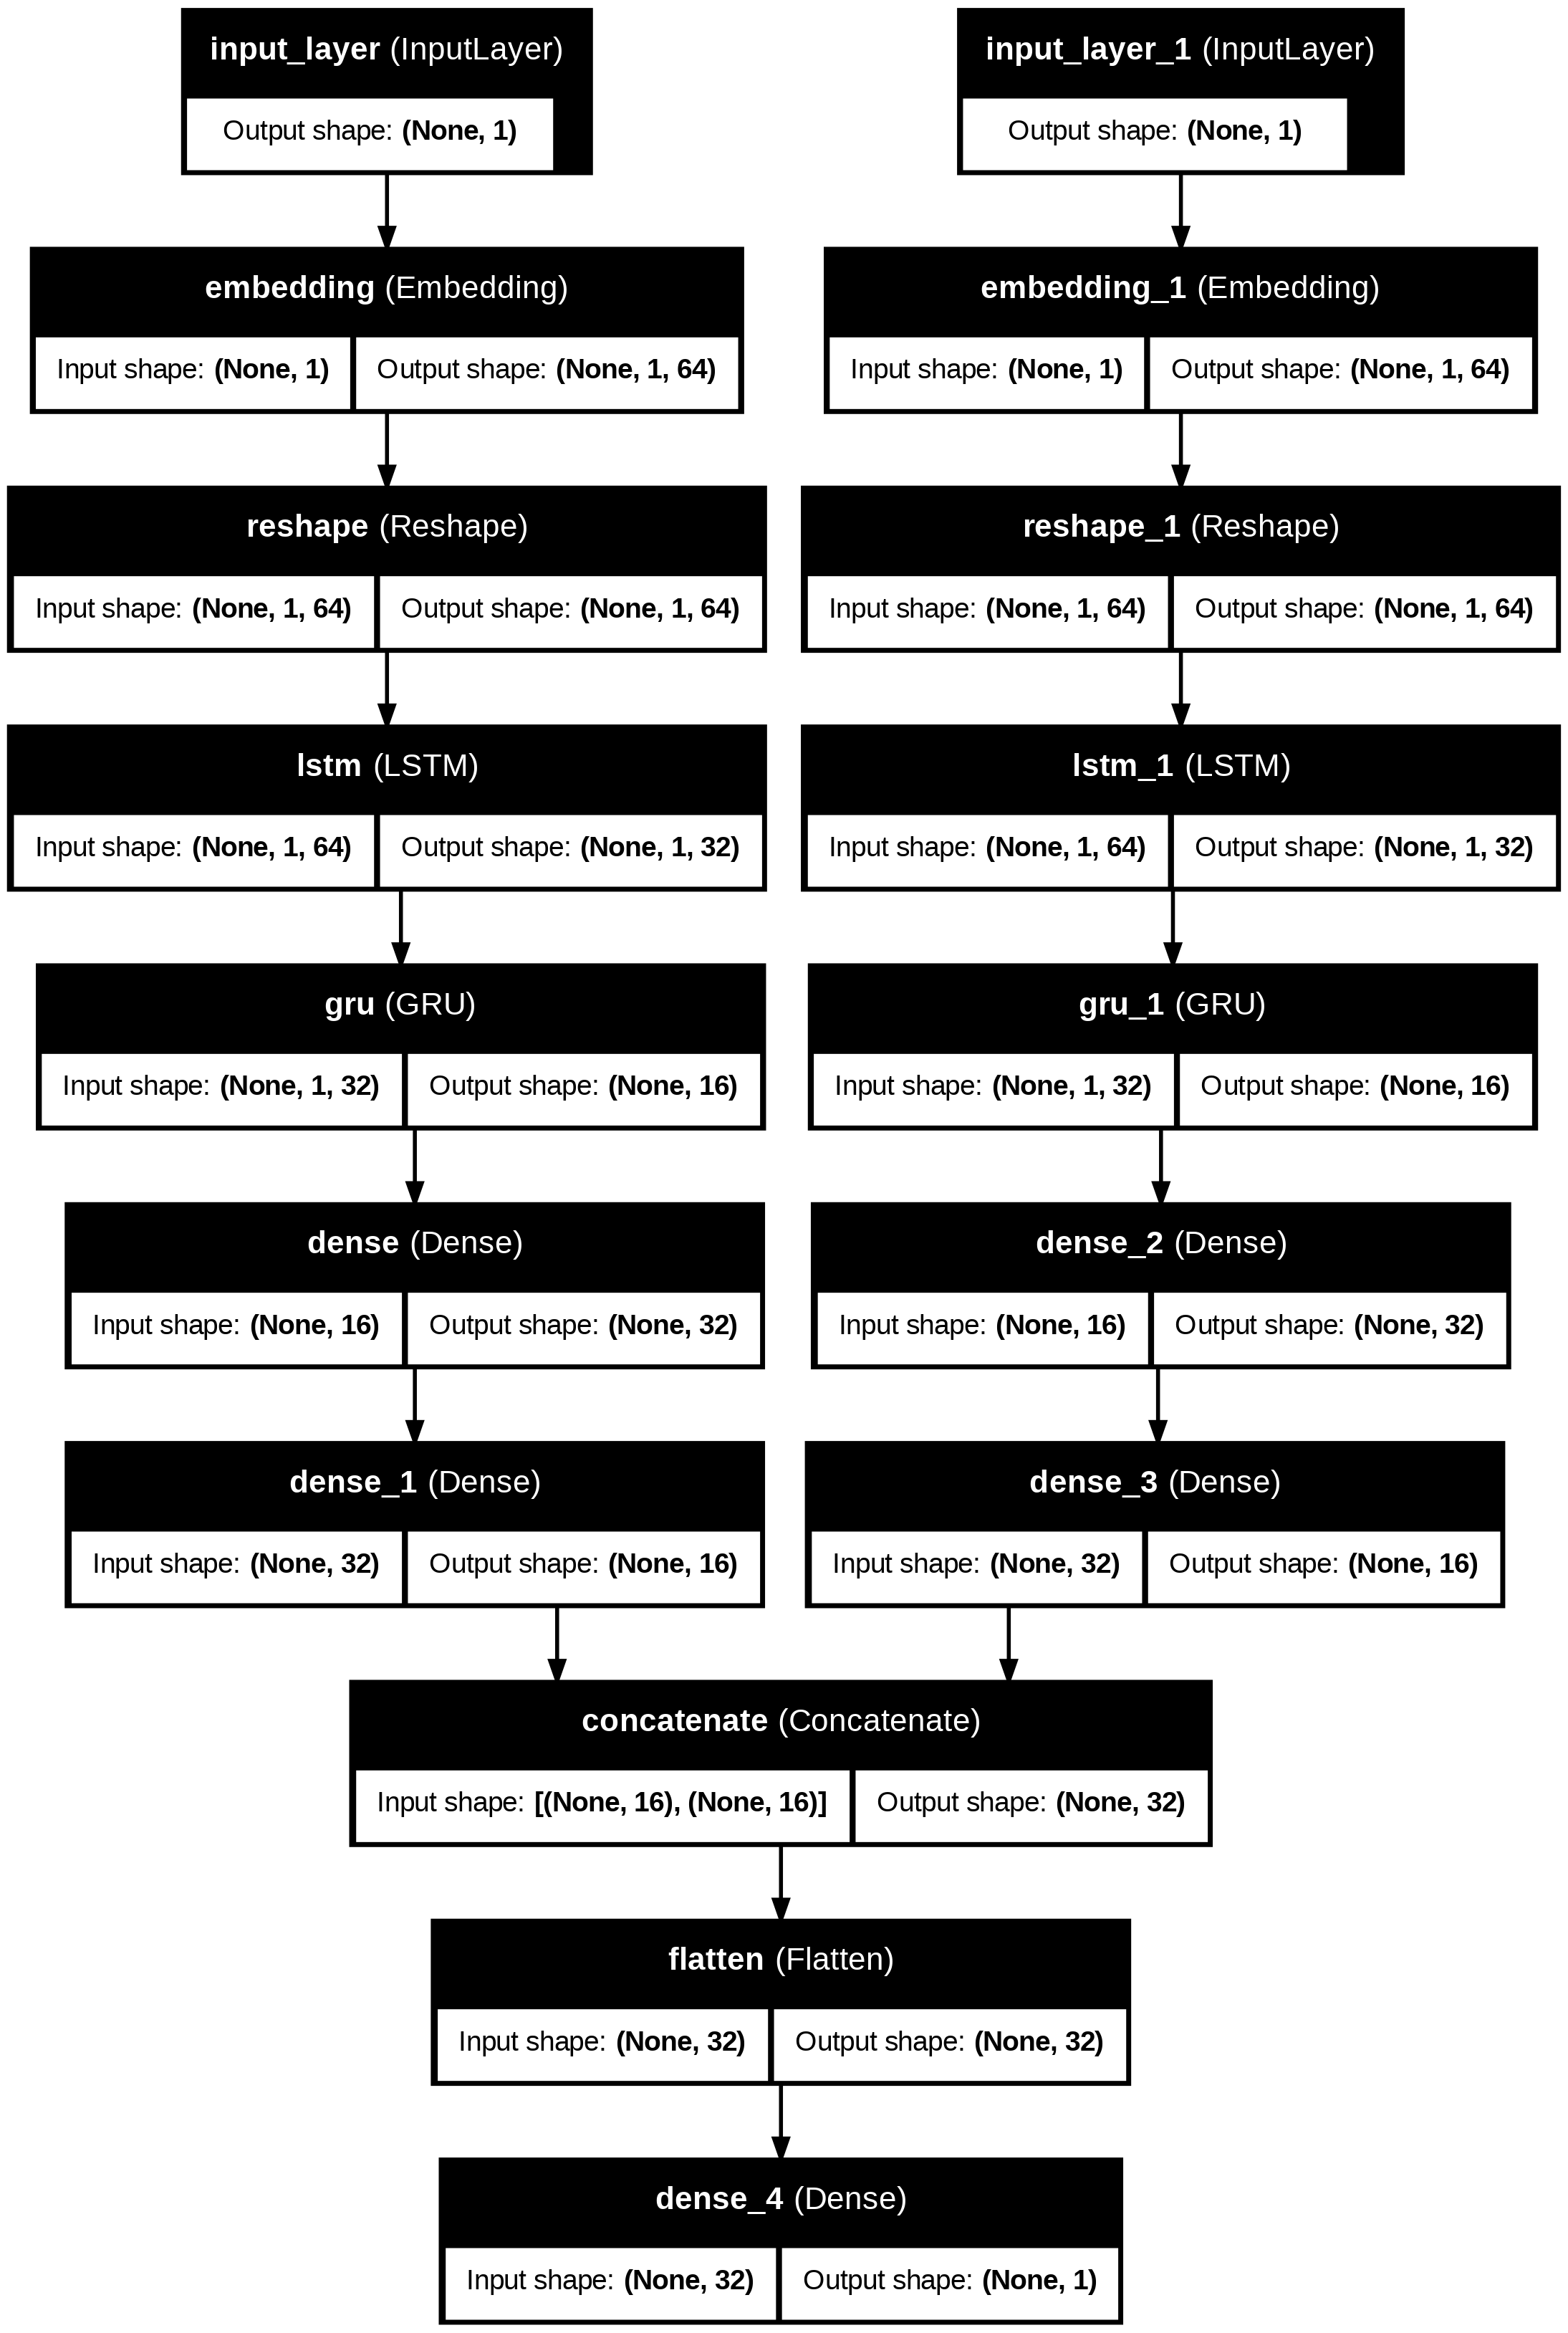

In [107]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_collaborative_based.png', show_shapes=True, show_layer_names=True)


In [108]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

adam = optimizers.Adam(learning_rate=lr_schedule)

# rmsprop = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
# optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, decay=1e-6)
# optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

loss = tf.keras.losses.MeanSquaredError()

#Callback
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)
# checkpoint_callback = checkpoint_call()

In [109]:
model.compile(optimizer=adam, loss=loss)

In [110]:
[train['user_index'], train['product_index']]

[431891          0
 946212          1
 156299          2
 451662          3
 1580130         4
             ...  
 2069868     12864
 1375608    151412
 153546       2506
 503813      14943
 1220421    208243
 Name: user_index, Length: 1707782, dtype: int64,
 431891         0
 946212         1
 156299         2
 451662         3
 1580130        4
            ...  
 2069868     9834
 1375608     5097
 153546      2214
 503813     26947
 1220421    26311
 Name: product_index, Length: 1707782, dtype: int64]

In [111]:
hist = model.fit([train['user_index'], train['product_index']], train['interaction_score'],
          validation_data = [[test['user_index'], test['product_index']], test['interaction_score']],
          epochs=15, batch_size=512, verbose=1)

Epoch 1/15
3336/3336 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 0.0614 - val_loss: 0.0567
Epoch 2/15
3336/3336 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 0.0465 - val_loss: 0.0556
Epoch 3/15
3336/3336 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.0443 - val_loss: 0.0557
Epoch 4/15
3336/3336 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 0.0437 - val_loss: 0.0557
Epoch 5/15
3336/3336 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.0437 - val_loss: 0.0557
Epoch 6/15
3336/3336 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 0.0438 - val_loss: 0.0557
Epoch 7/15
3336/3336 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.0438 - val_loss: 0.0557
Epoch 8/15
3336/3336 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.0439 - val_loss: 0.0557
Epoch 9/15
3336/3336 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0437 - val_loss: 0.0557
Epoch 10/15
3336/3336 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0436 - val_loss: 0.0557
Epoch 11/15
3336/3336 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 0.0437 - val_loss: 0.0557
Epoch 12/15
3336/33

In [112]:
loss = model.evaluate([test['user_index'], test['product_index']], test['interaction_score'])
print(f"Mean Squared Error on test data: {loss}")

11635/11635 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0562
Mean Squared Error on test data: 0.05570060759782791


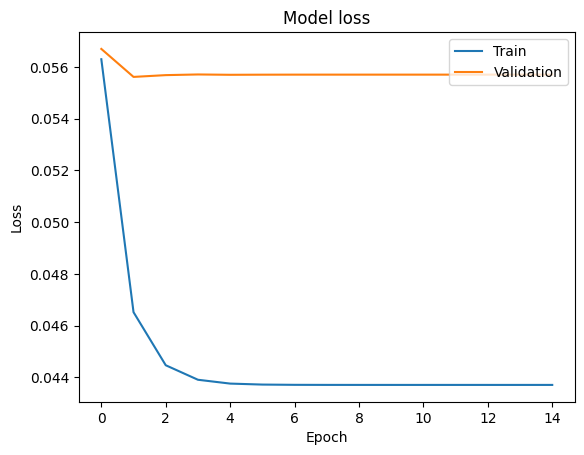

In [113]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('loss.png')
plt.show()

In [114]:
train['user_index']

,user_index
431891,0
946212,1
156299,2
451662,3
1580130,4
...,...
2069868,12864
1375608,151412
153546,2506
503813,14943


In [115]:
train['product_index'].iloc[0:1]

,product_index
431891,0


In [116]:
train['user_index'].iloc[0:1]

,user_index
431891,0


In [117]:
model.predict([train['user_index'].iloc[0:1],train['product_index'].iloc[0:1]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.11395763]], dtype=float32)

## 3.2. Content-based by Neural Network

In [118]:
def create_featureTable(interactionTable):
    featureTable = merge_dataframe([interactionTable, userTable], on='user_id', suffixes=('','_user'))
    featureTable = merge_dataframe([featureTable, productTable], on='product_id', suffixes=('_user','_product'))
    featureTable.drop(columns=['first_date_user', 'last_date_user', 'first_date_product', 'last_date_product'], inplace=True)

    return featureTable

featureTable = create_featureTable(interactionTable)

In [119]:
train_name = f'{name}_train'
#featureTable.to_csv(f'{input_path}\\clean\\{train_name}.csv')

In [120]:
featureTable

,user_id,user_index,product_id,product_index,interaction_score,views_user,carts_user,remove_from_carts_user,purchases_user,avg_view_price,...,avg_price,relative_price,views_product,carts_product,remove_from_carts_product,purchases_product,cart_per_view_product,purchase_per_view_product,remove_per_cart_product,purchase_per_cart_product
0,256480321,0,5864578,0,12.533717,250,94,83,15,20.702760,...,26.35,1.212876,158,9,6,3,0.004724,0.004286,0.007194,0.004286
1,546464358,1,5872979,1,8.268916,147,0,0,0,8.890000,...,8.89,0.713643,285,53,26,4,0.027822,0.005714,0.031175,0.005714
2,564294357,2,5834157,2,6.484251,40,8,2,6,5.422500,...,5.71,-0.325472,369,76,40,20,0.039895,0.028571,0.047962,0.028571
3,543878923,3,5013,3,5.963198,102,12,8,0,2.303529,...,1.27,-0.177778,1298,1045,465,366,0.548556,0.522857,0.557554,0.522857
4,550388516,4,5885321,4,5.579634,3086,0,1,0,7.905055,...,12.98,0.844758,238,19,11,2,0.009974,0.002857,0.013189,0.002857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134723,445287623,35441,5797964,10552,0.000000,28,101,144,0,4.146071,...,3.95,1.423423,22,14,8,4,0.007349,0.005714,0.009592,0.005714
2134724,525071537,69,5788138,9576,0.000000,279,226,171,73,10.792151,...,6.35,6.161290,30,30,17,3,0.015748,0.004286,0.020384,0.004286
2134725,406644045,3907,5755451,19948,0.000000,19,27,18,11,5.884211,...,3.97,0.000000,44,22,9,5,0.011549,0.007143,0.010791,0.007143
2134726,517169269,38372,5886712,3858,0.000000,2,1,1,0,1.585000,...,2.38,0.000000,34,37,24,5,0.019423,0.007143,0.028777,0.007143


In [121]:
featureTable.columns

Index(['user_id', 'user_index', 'product_id', 'product_index',
       'interaction_score', 'views_user', 'carts_user',
       'remove_from_carts_user', 'purchases_user', 'avg_view_price',
       'avg_purchase_price', 'avg_view_relative_price',
       'avg_purchase_relative_price', 'distinct_view_product',
       'distinct_cart_product', 'distinct_remove_product',
       'distinct_purchase_product', 'cart_per_view_user',
       'purchase_per_view_user', 'remove_per_cart_user',
       'purchase_per_cart_user', 'category_id', 'avg_price', 'relative_price',
       'views_product', 'carts_product', 'remove_from_carts_product',
       'purchases_product', 'cart_per_view_product',
       'purchase_per_view_product', 'remove_per_cart_product',
       'purchase_per_cart_product'],
      dtype='object')

In [122]:
# train test split
train, test = train_test_split(featureTable, test_size=0.1, random_state=42)
dev, test = train_test_split(test, test_size=0.5, random_state=42)

# attributes
attributes =['interaction_score', 'user_index', 'views_user', 'carts_user',
            'remove_from_carts_user', 'purchases_user', 'avg_view_price',
            'avg_purchase_price', 'avg_view_relative_price',
            'avg_purchase_relative_price', 'distinct_view_product',
            'distinct_cart_product', 'distinct_remove_product',
            'distinct_purchase_product', 'cart_per_view_user',
            'purchase_per_view_user', 'remove_per_cart_user',
            'purchase_per_cart_user',
            'product_index', 'category_id', 'avg_price', 'relative_price', 'views_product',
            'carts_product', 'remove_from_carts_product', 'purchases_product',
            'cart_per_view_product', 'purchase_per_view_product',
            'remove_per_cart_product', 'purchase_per_cart_product']

# user and product attributes
user_attr = attributes[1:18]
product_attr = attributes[18:]
target = 'interaction_score'

train

,user_id,user_index,product_id,product_index,interaction_score,views_user,carts_user,remove_from_carts_user,purchases_user,avg_view_price,...,avg_price,relative_price,views_product,carts_product,remove_from_carts_product,purchases_product,cart_per_view_product,purchase_per_view_product,remove_per_cart_product,purchase_per_cart_product
1627663,558638951,336546,5809910,45,0.037893,1,0,0,0,5.240000,...,5.24,0.000000,8473,1052,354,311,0.552231,0.444286,0.424460,0.444286
2016766,475058127,52896,60183,5310,0.000000,4,10,9,0,5.077500,...,1.98,0.161290,146,169,98,53,0.088714,0.075714,0.117506,0.075714
830324,565958403,14587,5864851,2721,0.100000,23,46,0,0,5.698261,...,11.11,0.677180,606,109,70,23,0.057218,0.032857,0.083933,0.032857
1272464,555954521,267051,5747967,20104,0.060151,1,0,0,0,19.050000,...,19.05,-0.333333,118,9,6,1,0.004724,0.001429,0.007194,0.001429
1623805,493463294,13736,5692024,3901,0.037893,43,9,1,8,3.562326,...,5.32,-0.117312,296,83,38,21,0.043570,0.030000,0.045564,0.030000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003274,551437039,83826,5569508,9818,0.000000,72,5,9,0,5.774028,...,4.60,0.103333,28,32,21,11,0.016798,0.015714,0.025180,0.015714
1570006,559628853,325614,5694173,751,0.041562,5,0,0,0,16.634000,...,20.00,1.014197,184,56,26,16,0.029396,0.022857,0.031175,0.022857
732180,405209796,118454,5773206,18792,0.120303,30,14,0,0,12.931667,...,2.62,0.000000,39,38,25,8,0.019948,0.011429,0.029976,0.011429
110268,539668701,16076,5802438,20297,0.750000,69,11,3,12,15.748696,...,7.14,0.572165,32,9,9,1,0.004724,0.001429,0.010791,0.001429


In [123]:
user_size = len(user_attr)
product_size = len(product_attr)
print('User size: {}, product size: {}'.format(user_size, product_size))

User size: 17, product size: 12


In [124]:
# import tensorflow as tf
from tensorflow.keras.utils import plot_model
# num_outputs = 32


# # Define the user input model
# input_user = tf.keras.layers.Input(shape=(user_size,))
# reshape_user = tf.keras.layers.Reshape((1, user_size))(input_user)  # Reshape to 3D for LSTM/GRU
# lstm_user = tf.keras.layers.LSTM(128, activation='relu', return_sequences=True)(reshape_user)
# gru_user = tf.keras.layers.GRU(64, activation='relu', return_sequences=False)(lstm_user)
# dense1_user = tf.keras.layers.Dense(256, activation='relu')(gru_user)
# dense2_user = tf.keras.layers.Dense(128, activation='relu')(dense1_user)
# output_user = tf.keras.layers.Dense(num_outputs, activation='linear')(dense2_user)

# vu = tf.linalg.l2_normalize(output_user, axis=1)

# # Define the product input model
# input_product = tf.keras.layers.Input(shape=(product_size,))
# reshape_product = tf.keras.layers.Reshape((1, product_size))(input_product)  # Reshape to 3D for LSTM/GRU
# lstm_product = tf.keras.layers.LSTM(128, activation='relu', return_sequences=True)(reshape_product)
# gru_product = tf.keras.layers.GRU(64, activation='relu', return_sequences=False)(lstm_product)
# dense1_product = tf.keras.layers.Dense(256, activation='relu')(gru_product)
# dense2_product = tf.keras.layers.Dense(128, activation='relu')(dense1_product)
# output_product = tf.keras.layers.Dense(num_outputs, activation='linear')(dense2_product)

# vm = tf.linalg.l2_normalize(output_product, axis=1)

# # Compute the dot product of the normalized outputs
# output = tf.keras.layers.Dot(axes=1)([vu, vm])

# # Create the model
# model = tf.keras.models.Model(inputs=[input_user, input_product], outputs=output)

# # Print model summary
# model.summary()

from tensorflow.keras.layers import Input, Reshape, LSTM, GRU, Dense, Dot, Dropout, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

num_outputs = 32

# Define the user input model with modifications
input_user = Input(shape=(user_size,))
reshape_user = Reshape((1, user_size))(input_user)
lstm_user = LSTM(256, activation='relu', return_sequences=True)(reshape_user)
gru_user = GRU(128, activation='relu', return_sequences=False)(lstm_user)
dense1_user = Dense(256, activation='relu')(gru_user)
dropout_user = Dropout(0.2)(dense1_user)
batch_norm_user = BatchNormalization()(dropout_user)
dense2_user = Dense(128, activation='relu')(batch_norm_user)
output_user = Dense(num_outputs, activation='linear')(dense2_user)
vu = Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1))(output_user)

# Define the product input model with similar modifications
input_product = Input(shape=(product_size,))
reshape_product = Reshape((1, product_size))(input_product)
lstm_product = LSTM(256, activation='relu', return_sequences=True)(reshape_product)
gru_product = GRU(128, activation='relu', return_sequences=False)(lstm_product)
dense1_product = Dense(256, activation='relu')(gru_product)
dropout_product = Dropout(0.2)(dense1_product)
batch_norm_product = BatchNormalization()(dropout_product)
dense2_product = Dense(128, activation='relu')(batch_norm_product)
output_product = Dense(num_outputs, activation='linear')(dense2_product)
vm = Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1))(output_product)



# Normalize product output
vm = Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1))(output_product)

# Compute the dot product of the normalized outputs
output = Dot(axes=1)([vu, vm])

# Create the model
model = Model(inputs=[input_user, input_product], outputs=output)

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 17)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 1, 17)          │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 1, 12)          │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 1, 256)         │        280,576 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 1, 256)         │        275,456 │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_2 (GRU)               │ (None, 128)            │        148,224 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_3 (GRU)               │ (None, 128)            │        148,224 │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 256)            │         33,024 │ gru_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │         33,024 │ gru_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256)            │          1,024 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256)            │          1,024 │ dropout_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │         32,896 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 128)            │         32,896 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 32)             │          4,128 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)     

 Total params: 994,624 (3.79 MB)

 Trainable params: 993,600 (3.79 MB)

 Non-trainable params: 1,024 (4.00 KB)

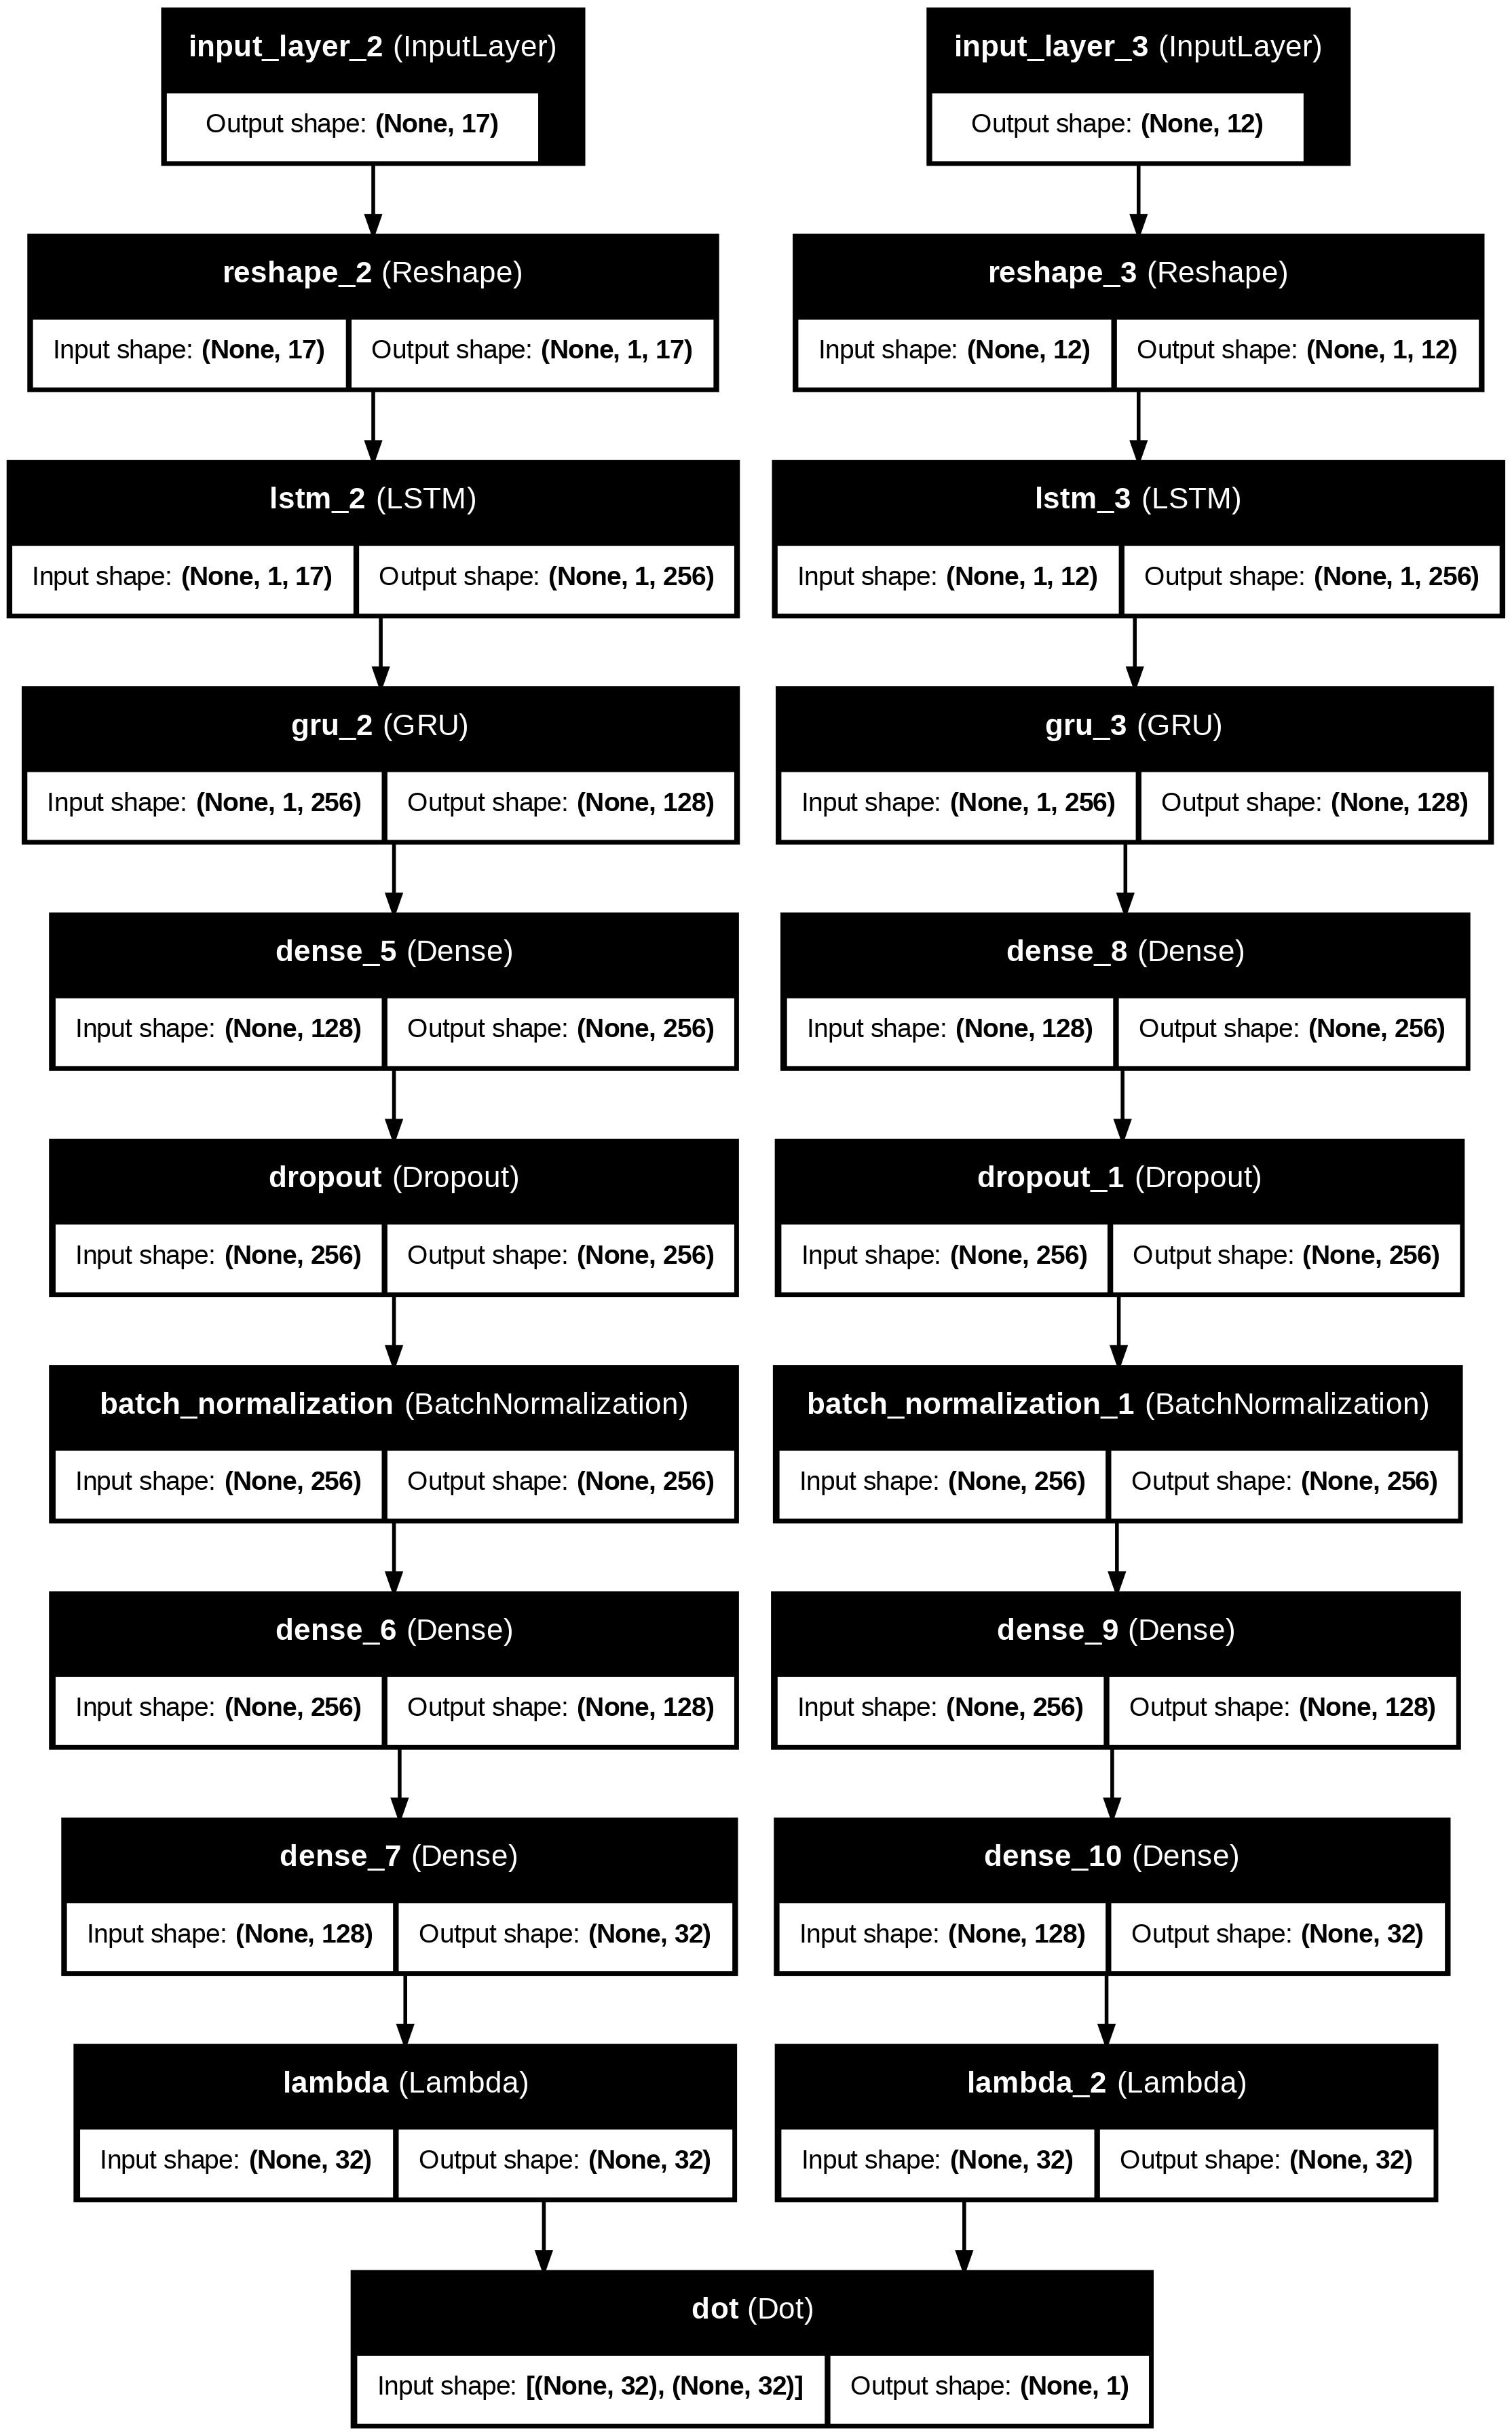

In [125]:
# Plot the model
plot_model(model, to_file='model_plot_content_based.png', show_shapes=True, show_layer_names=True)

In [126]:
# # build model
# def ContentBaseModel():

#     num_outputs = 32
#     tf.random.set_seed(1)

#     user_NN = tf.keras.models.Sequential([
#         tf.keras.layers.Reshape((1, user_size), input_shape=(user_size,)),  # Reshape to 3D for LSTM/GRU
#         tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
#         tf.keras.layers.GRU(64, activation='relu', return_sequences=False),
#         tf.keras.layers.Dense(256, activation='relu'),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(num_outputs, activation='linear')
#     ])


#     # Define the product model with LSTM and GRU layers
#     product_NN = tf.keras.models.Sequential([
#         tf.keras.layers.Reshape((1, product_size), input_shape=(product_size,)),  # Reshape to 3D for LSTM/GRU
#         tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
#         tf.keras.layers.GRU(64, activation='relu', return_sequences=False),
#         tf.keras.layers.Dense(256, activation='relu'),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(num_outputs, activation='linear')
#     ])

#     # create the user input and point to the base network
#     input_user = tf.keras.layers.Input(shape=(user_size))
#     vu = user_NN(input_user)
#     vu = tf.linalg.l2_normalize(vu, axis=1)

#     # create the item input and point to the base network
#     input_item = tf.keras.layers.Input(shape=(product_size))
#     vm = product_NN(input_item)
#     vm = tf.linalg.l2_normalize(vm, axis=1)

#     # compute the dot product of the two vectors vu and vm
#     output = tf.keras.layers.Dot(axes=1)([vu, vm])

#     model = tf.keras.models.Model(inputs=[input_user, input_item], outputs=output)

#     return model

# model = ContentBaseModel()
# model.summary()

In [127]:
# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100,
#     decay_rate=0.96,
#     staircase=True)

# # adam = optimizers.Adam(learning_rate=0.001,, decay=1e-6)
# adam = optimizers.Adam(learning_rate=0.001)
# # rmsprop = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
# # sgd = keras.optimizers.SGD(learning_rate=lr_schedule)

# loss = tf.keras.losses.MeanSquaredError()
initial_learning_rate = 0.0005
adam = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, decay=1e-6)
loss = tf.keras.losses.MeanSquaredError()

#Callback
# logdir = 'logs'
# tensorboard_callback = TensorBoard(log_dir=logdir)
# checkpoint_callback = checkpoint_call()

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning:

Argument `decay` is no longer supported and will be ignored.



In [128]:
model.compile(optimizer=adam,loss=loss)

In [129]:
train[user_attr]

,user_index,views_user,carts_user,remove_from_carts_user,purchases_user,avg_view_price,avg_purchase_price,avg_view_relative_price,avg_purchase_relative_price,distinct_view_product,distinct_cart_product,distinct_remove_product,distinct_purchase_product,cart_per_view_user,purchase_per_view_user,remove_per_cart_user,purchase_per_cart_user
1627663,336546,1,0,0,0,5.240000,0.000000,0.000000,0.000000,1,0,0,0,0.000000,0.000000,0.000000,0.000000
2016766,52896,4,10,9,0,5.077500,4.719000,0.160473,0.095721,3,10,9,0,0.009542,0.000000,0.006939,0.000000
830324,14587,23,46,0,0,5.698261,3.359565,0.584252,-0.848720,21,45,0,0,0.043893,0.000000,0.000000,0.000000
1272464,267051,1,0,0,0,19.050000,0.000000,-0.333333,0.000000,1,0,0,0,0.000000,0.000000,0.000000,0.000000
1623805,13736,43,9,1,8,3.562326,1.705556,0.078345,-0.568801,30,9,1,8,0.008588,0.024316,0.000771,0.024316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003274,83826,72,5,9,0,5.774028,2.990000,0.696155,-0.370917,71,5,9,0,0.004771,0.000000,0.006939,0.000000
1570006,325614,5,0,0,0,16.634000,0.000000,0.913665,0.000000,5,0,0,0,0.000000,0.000000,0.000000,0.000000
732180,118454,30,14,0,0,12.931667,3.011429,0.641257,0.071643,22,14,0,0,0.013359,0.000000,0.000000,0.000000
110268,16076,69,11,3,12,15.748696,2.087273,0.908121,-0.208295,62,11,3,12,0.010496,0.036474,0.002313,0.036474


In [130]:
train[product_attr]

,product_index,category_id,avg_price,relative_price,views_product,carts_product,remove_from_carts_product,purchases_product,cart_per_view_product,purchase_per_view_product,remove_per_cart_product,purchase_per_cart_product
1627663,45,1602943681873052386,5.24,0.000000,8473,1052,354,311,0.552231,0.444286,0.424460,0.444286
2016766,5310,1487580009445982239,1.98,0.161290,146,169,98,53,0.088714,0.075714,0.117506,0.075714
830324,2721,1487580005268456287,11.11,0.677180,606,109,70,23,0.057218,0.032857,0.083933,0.032857
1272464,20104,1487580007894090712,19.05,-0.333333,118,9,6,1,0.004724,0.001429,0.007194,0.001429
1623805,3901,1487580009143992338,5.32,-0.117312,296,83,38,21,0.043570,0.030000,0.045564,0.030000
...,...,...,...,...,...,...,...,...,...,...,...,...
2003274,9818,1487580012969197740,4.60,0.103333,28,32,21,11,0.016798,0.015714,0.025180,0.015714
1570006,751,1487580007852147670,20.00,1.014197,184,56,26,16,0.029396,0.022857,0.031175,0.022857
732180,18792,1487580005134238553,2.62,0.000000,39,38,25,8,0.019948,0.011429,0.029976,0.011429
110268,20297,2151191070984110951,7.14,0.572165,32,9,9,1,0.004724,0.001429,0.010791,0.001429


In [131]:
# hist = model.fit([train[user_attr], train[product_attr]], train[target],
#           validation_data = [[dev[user_attr], dev[product_attr]], dev[target]],
#           epochs=4, batch_size=512, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit([train[user_attr], train[product_attr]], train[target],
                 validation_data=([dev[user_attr], dev[product_attr]], dev[target]),
                 epochs=10, batch_size=512, verbose=1, callbacks=[early_stopping])

Epoch 1/10
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.0614 - val_loss: 0.0568
Epoch 2/10
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.0556 - val_loss: 0.0545
Epoch 3/10
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0537 - val_loss: 0.0537
Epoch 4/10
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.0525 - val_loss: 0.0521
Epoch 5/10
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0517 - val_loss: 0.0515
Epoch 6/10
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0491 - val_loss: 0.0508
Epoch 7/10
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.0487 - val_loss: 0.0480
Epoch 8/10
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0482 - val_loss: 0.0482
Epoch 9/10
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.0479 - val_loss: 0.0478
Epoch 10/10
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0478 - val_loss: 0.0491


In [132]:
loss = model.evaluate([test[user_attr], test[product_attr]], test[target])
print(f"Mean Squared Error on test data: {loss}")

3336/3336 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0477
Mean Squared Error on test data: 0.048132479190826416


In [133]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Assume X_train, y_train, X_test, y_test are preprocessed and available

# # Track the start time for training
# start_time = time.time()

# # Train the RNN model
# # model.fit(X_train, y_train, epochs=10, batch_size=32)
# hist = model.fit([train[user_attr], train[product_attr]], train[target],
#           validation_data = [[dev[user_attr], dev[product_attr]], dev[target]],
#           epochs=2, batch_size=512, verbose=1)

# # Track the end time for training
# training_time = time.time() - start_time
# print(f"Training Time: {training_time:.2f} seconds")

# # Measure inference time
# start_time = time.time()
# y_pred = model.predict([test[user_attr], test[product_attr]])
# inference_time = (time.time() - start_time) / len([test[user_attr], test[product_attr]])
# print(f"Inference Time per Sample: {inference_time:.5f} seconds")

# # Convert predictions to class labels if necessary
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = test[target].astype(int)

# # Calculate performance metrics
# accuracy = accuracy_score(y_true , y_pred_classes)
# precision = precision_score(y_true, y_pred_classes, average="weighted")
# recall = recall_score(y_true, y_pred_classes, average="weighted")
# f1 = f1_score(y_true, y_pred_classes, average="weighted")

# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")


## Model pipeline

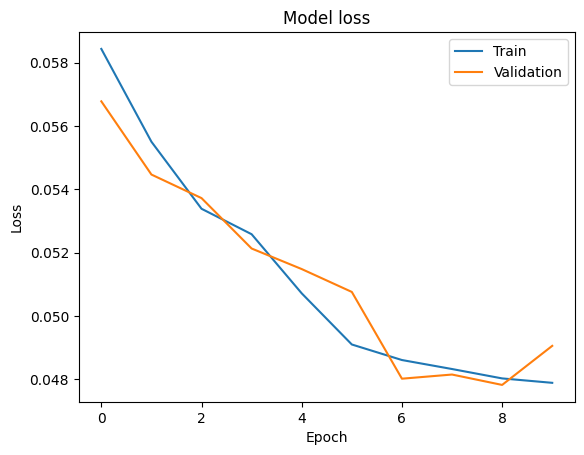

In [134]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('loss.png')
plt.show()

In [135]:
def evaluate_model(y_true, y_pred):
    mae = sklearn.metrics.mean_absolute_error(y_true, y_pred)
    mse = sklearn.metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    return mae, rmse

In [136]:
l_predict=[]
for i in model.predict([test[user_attr], test[product_attr]]):
    l_predict.append(i[0])

3336/3336 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


In [137]:
l_predict.sort(reverse=True)
print(l_predict)

[0.9937856, 0.9935952, 0.9923991, 0.99205697, 0.9919443, 0.99151504, 0.9914756, 0.9906425, 0.99020076, 0.9892013, 0.9892013, 0.98903835, 0.98903835, 0.9885527, 0.9884778, 0.9877984, 0.9876658, 0.9876658, 0.98736656, 0.9872987, 0.98599625, 0.98599625, 0.98599625, 0.98597485, 0.9859405, 0.9859405, 0.9859086, 0.9850638, 0.98373234, 0.98373234, 0.98324895, 0.98317415, 0.98317415, 0.9827261, 0.98229074, 0.98079836, 0.9793031, 0.9791225, 0.97758055, 0.97584134, 0.97394365, 0.97394365, 0.97394365, 0.9738561, 0.9723269, 0.97148395, 0.97039723, 0.96822035, 0.9679358, 0.9665857, 0.9659138, 0.96555233, 0.96555233, 0.965429, 0.965429, 0.9647678, 0.9643206, 0.9642011, 0.9638485, 0.9638485, 0.9638485, 0.963131, 0.9621931, 0.9616982, 0.96152425, 0.96145415, 0.9606943, 0.96026367, 0.96007323, 0.96007323, 0.95909655, 0.9589991, 0.9582242, 0.9571595, 0.95703936, 0.95692044, 0.9555958, 0.9555958, 0.95545244, 0.95545244, 0.9549367, 0.9547942, 0.9541471, 0.9541471, 0.9539354, 0.9537698, 0.9537698, 0.953461

In [138]:
evaluate_model(test[target],l_predict)

(0.19276051425817683, 0.2989792862553083)